## Описание проекта

Данные находятся в трёх файлах:
- `gold_recovery_train_new.csv` — обучающая выборка;
- `gold_recovery_test_new.csv` — тестовая выборка;
- `gold_recovery_full_new.csv` — исходные данные.

Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.

Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

## Import

In [ ]:
!pip install catboost

In [ ]:
# data
import pandas as pd
import numpy as np
import scipy as sc
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import probplot

In [ ]:
# preprocessing
from sklearn.metrics import (
    mean_absolute_error as mae,
    mean_squared_error as mse
    )
from tqdm import tqdm
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    PolynomialFeatures,
    KBinsDiscretizer
    )
# models
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor

Ячейка для констант

In [ ]:
SEED = 7 # random state
CAT_COL, REAL_FIN_COL, REAL_ROU_COL, BINS_COL = None, None, None, None
BINS = 50
N_SPLITS = 7

## Обзор и предобработка данных

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

try:
    data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
    data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
    data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
except:
    data_full = pd.read_csv('../data/gold_recovery_full_new.csv')
    data_train = pd.read_csv('../data/gold_recovery_train_new.csv')
    data_test = pd.read_csv('../data/gold_recovery_test_new.csv')

Рассмотрим каждый датасет по отдельности

### Full

In [ ]:
def check_my_data(df):
    display(df.describe())
    print()
    print(f'This data has {df.shape[0]} obj and {df.shape[1]} features \n with {df.dtypes.unique()} dtypes')
    print()
    if all(df.isna().sum() == 0):
        print('Data hasn`t NA')
    else:
        disna = df.isna().sum().loc[df.isna().sum() != 0]
        print(f'{disna.shape[0]} columns with NA')
        display(disna.sort_values(ascending=False))
    print()
    print(f'Data has {df.duplicated().sum()} duplicates')

In [ ]:
check_my_data(data_full)

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,19402.000000,19439.000000,19335.000000,19439.000000,19323.000000,19069.000000,19439.000000,19435.000000,19418.000000,19377.000000,19439.000000,1.943500e+04,19438.000000,1.943500e+04,19438.000000,1.943700e+04,19438.000000,1.943600e+04,19438.000000,1.943700e+04,19437.000000,19437.000000,19439.000000,19439.000000,19339.000000,19428.000000,19294.000000,19340.000000,19439.000000,19405.000000,19431.000000,19395.000000,18986.000000,19439.000000,19439.000000,19416.000000,19439.000000,19439.000000,19438.000000,19439.000000,19439.000000,19439.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19439.000000,19439.000000,19003.000000,19439.000000,19439.000000,19439.000000,19437.000000,19427.000000,17691.000000,19439.000000,19219.000000,19438.000000,19416.000000,19438.000000,19426.000000,19438.000000,19438.000000,19438.000000,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438


This data has 19439 obj and 87 features 
 with [dtype('O') dtype('float64')] dtypes

63 columns with NA


secondary_cleaner.output.tail_sol                     1748
rougher.input.floatbank11_xanthate                     453
rougher.state.floatbank10_e_air                        436
primary_cleaner.output.concentrate_sol                 370
secondary_cleaner.state.floatbank2_a_air               220
final.output.concentrate_sol                           211
rougher.input.feed_size                                145
primary_cleaner.output.concentrate_pb                  116
primary_cleaner.input.xanthate                         104
final.output.tail_pb                                   101
rougher.input.feed_pb                                  100
rougher.input.feed_sol                                  99
primary_cleaner.output.tail_sol                         62
rougher.input.floatbank11_sulfate                       44
primary_cleaner.input.depressant                        37
rougher.input.floatbank10_sulfate                       34
primary_cleaner.input.sulfate                           


Data has 0 duplicates


В исходных данных 19439 объектов и 87 признаков. В 63 признаках есть пропуски, в основном пропусков меньше 10, но есть и колонки, где количество пропусков почти 2 тысячи. В данных отсутствуют дубликаты

### Train

In [ ]:
check_my_data(data_train)

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,14117.000000,14149.000000,14049.000000,14149.000000,14063.000000,13863.000000,14149.000000,14148.000000,14134.000000,14103.000000,14149.000000,14145.000000,14148.000000,14145.000000,14148.000000,14147.000000,14148.000000,14146.000000,14148.000000,1.414800e+04,14148.000000,14148.000000,14149.000000,14149.000000,14049.000000,14141.000000,14005.000000,14071.000000,14149.000000,14120.000000,14141.000000,14113.000000,13721.000000,14149.000000,14149.000000,14127.000000,14149.000000,14149.000000,14148.000000,14149.000000,14149.000000,14149.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14149.000000,14149.000000,13713.000000,14149.000000,14149.000000,14149.000000,14147.000000,14139.000000,12544.000000,14149.000000,13932.000000,14148.000000,14128.000000,14148.000000,14145.000000,14148.000000,14148.000000,14148.000000,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148


This data has 14149 obj and 87 features 
 with [dtype('O') dtype('float64')] dtypes

62 columns with NA


secondary_cleaner.output.tail_sol                     1605
rougher.state.floatbank10_e_air                        436
rougher.input.floatbank11_xanthate                     428
primary_cleaner.output.concentrate_sol                 286
secondary_cleaner.state.floatbank2_a_air               217
final.output.concentrate_sol                           211
rougher.input.feed_size                                144
final.output.tail_pb                                   100
rougher.input.feed_pb                                  100
primary_cleaner.input.xanthate                         100
primary_cleaner.output.concentrate_pb                   86
rougher.input.feed_sol                                  78
primary_cleaner.output.tail_sol                         46
rougher.input.floatbank11_sulfate                       36
primary_cleaner.input.depressant                        32
rougher.input.floatbank10_sulfate                       29
rougher.output.concentrate_sol                          


Data has 0 duplicates


Тренировочный датасет с виду ничем не отличается от исходных данных. Ситуация схожа с ситуацией в исходных данных

### Test

In [ ]:
check_my_data(data_test)

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5287.000000,5289.000000,5269.000000,5290.000000,5285.000000,5290.000000,5282.000000,5265.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5287.000000,5290.000000,5288.000000,5290.000000,5281.000000,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,1.544844e+03,-500.199527,9.371940,3.798082,489.800620,55.951097,37.716648,9.334682,13.855759,6.467745,13.922328,6.512103,1053.400166,-395.732530,1318.926879,-475.241428,1301.595477,-474.836671,1214.847960,-475.682272,1056.648995,-469.029688,997.949719,-470.482465,26.312630,-502.750897,21.949119,-501.987097,25.402926,-507.490314,2.098211e+01,-506.627916,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,1.247731e+02,31.045257,1.926264,0.954859,108.036326,19.081758,5.491415,1.619521,3.350852,1.065114,3.223769,0.886989,121.139309,91.085505,156.450366,45.649466,171.269667,45.859866,185.763319,47.844967,131.542839,59.325990,128.218869,60.759318,3.429852,28.756505,4.354961,34.582722,6.526457,47.620908,6.736179e+00,44.528673,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,4.039220e-32,-799.794250,0.568441,0.273677,0.002986,0.046369,1.393488,0.568632,0.001147,0.000568,0.000077,0.006985,-0.042069,-657.949759,-0.721806,-650.245277,-0.056636,-647.544439,-0.992219,-648.390665,-1.982295,-649.267537,-2.593390,-649.949283,0.20


This data has 5290 obj and 53 features 
 with [dtype('O') dtype('float64')] dtypes

12 columns with NA


rougher.input.floatbank11_xanthate          25
rougher.input.feed_sol                      21
secondary_cleaner.state.floatbank3_a_air     9
rougher.input.floatbank11_sulfate            8
primary_cleaner.input.depressant             5
rougher.input.floatbank10_sulfate            5
primary_cleaner.input.sulfate                4
primary_cleaner.input.xanthate               4
rougher.input.feed_rate                      3
secondary_cleaner.state.floatbank2_a_air     3
secondary_cleaner.state.floatbank2_b_air     2
rougher.input.feed_size                      1
dtype: int64


Data has 0 duplicates


В тестовом датафрейме колонок на 34 меньше чем в исходных данных. Пропущенных данных меньше, дубликаты отсутствуют

Расчёт средней абсолютной ошибки между рассчитанной эффективностью обогащения и представленной

In [ ]:
def formula(c, f, t):
    return ((c * (f - t)) / (f * (c - t))) * 100

In [ ]:
c, f, t = data_train['rougher.output.concentrate_au'], data_train['rougher.input.feed_au'], data_train['rougher.output.tail_au']
en = formula(c, f, t)

mae(data_train['rougher.output.recovery'], en)

9.73512347450521e-15

MAE между `rougher.output.recovery` и значениями из формулы очень мала, её можно считать погрешностью

Проанализируем колонки отсутствующие в тестовых данных

In [ ]:
columns_not_in_test = list(set(data_train.columns) - set(data_test.columns))
sorted(columns_not_in_test)

['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Мы видим, что в `data_test` отсутствуют такие столбцы, как `rougher.output.concentrate_au, rougher.output.tail_au`, которые нужны для расчёта эффективности обогащения. Из этого следуют, что нам нужно найти модель, с помощью которой мы сможем предсказывать такие храктеристики, как `final.output.recovery, rougher.output.recovery`

Из тестовой выборки были исключены признаки параметра продукта (`output`). Это то, что мы получаем на выходе.Эти признаки отсутствуют т.к. именно они дают оценку эффективности обогащения золотой руды.

Заполним пропущенные значения

In [ ]:
print(all(data_full['date'] == data_full['date'].sort_values()))
print(all(data_train['date'] == data_train['date'].sort_values()))
all(data_test['date'] == data_test['date'].sort_values())

True
True


True

Так как данные расположены в соответствии со временем, то заполним пропуски последним встречающимся значением

In [ ]:
data_full.fillna(inplace=True, method="ffill")
print(all(data_full.isna().sum() == 0))
data_train.fillna(inplace=True, method="ffill")
print(all(data_train.isna().sum() == 0))
data_test.fillna(inplace=True, method="ffill")
all(data_test.isna().sum() == 0)

True
True


True

Промежуточный вывод: в данном блоке мы познакомились с данными, узнали, что `rougher.output.recovery` посчитана верно. Проанализировали столбцы, которые отсутсвуют в тестовой выборке

## Анализ данных

Выведим гистограмы и графики квантиль-квантиль каждого признака из тренировочной, которые присутствуют в тестовой. Добавим названия столбцов для каждого таргета, если корреляция будет больше 0.05

In [ ]:
data_for_analisys = data_train.drop(columns_not_in_test, axis=1)
data_for_analisys.drop('date', axis=1, inplace=True)

In [ ]:
def show_hist_and_qqplot(df, feature):
    fig = plt.figure(figsize=(12, 8), constrained_layout=True)
    ax1 = plt.subplot2grid(shape=(1, 2), loc=(0, 0))
    ax2 = plt.subplot2grid(shape=(1, 2), loc=(0, 1))

    sns.histplot(df[feature], kde=True, bins=BINS, ax=ax1)
    ax1.set_title('Гистограмма распределения')

    probplot(df[feature], plot=ax2)
    ax2.set_title('Q-Q plot')

    plt.show()

primary_cleaner.input.sulfate


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


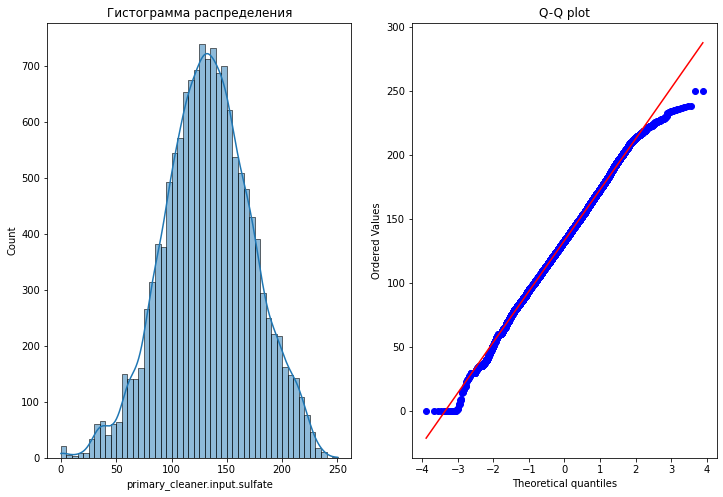

fin: 0.35587749070523583 rou: 0.27749585548208444

primary_cleaner.input.depressant


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


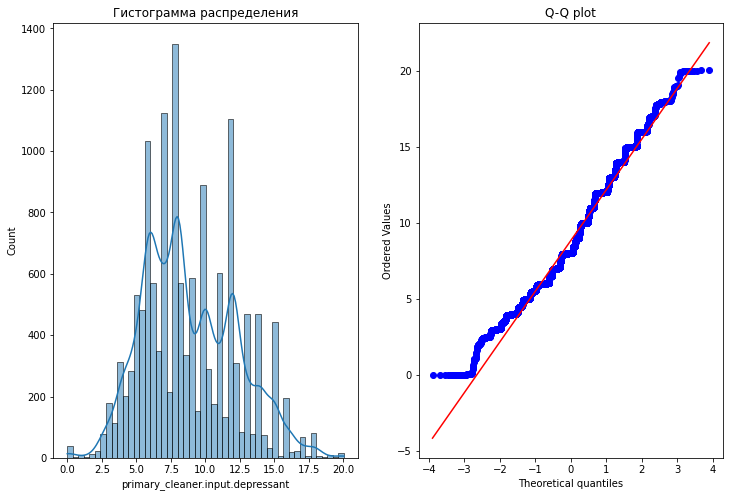

fin: 0.1614419073179312 rou: 0.05182703938696263

primary_cleaner.input.feed_size


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


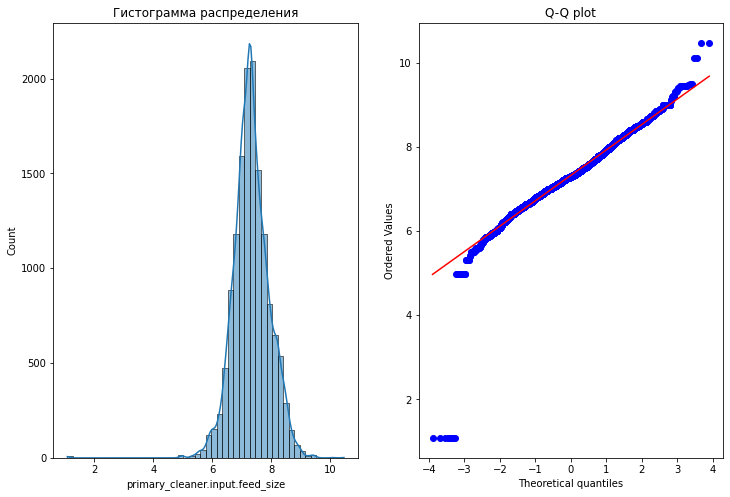

fin: 0.06339658235555984 rou: -0.011132941598577896

primary_cleaner.input.xanthate


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


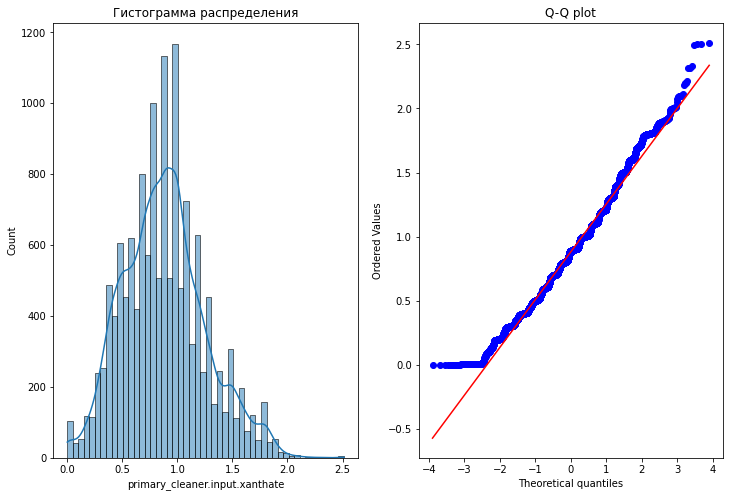

fin: 0.20593424438510588 rou: 0.1442266963715536

primary_cleaner.state.floatbank8_a_air


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


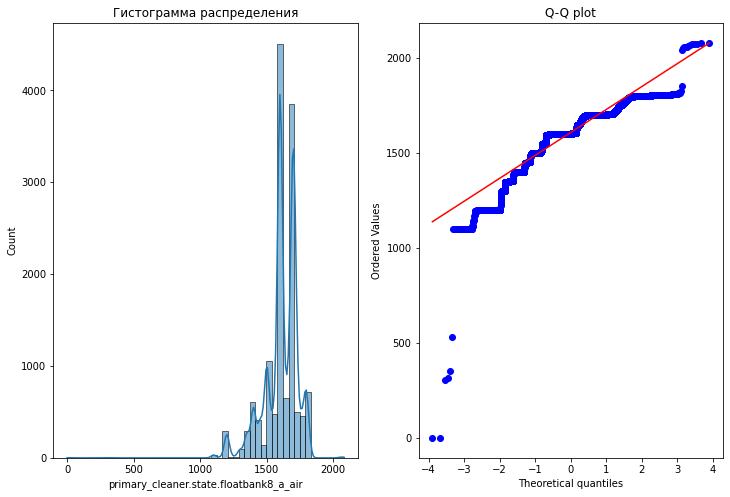

fin: 0.10681391170579378 rou: 0.09682676771087026

primary_cleaner.state.floatbank8_a_level

primary_cleaner.state.floatbank8_b_air


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


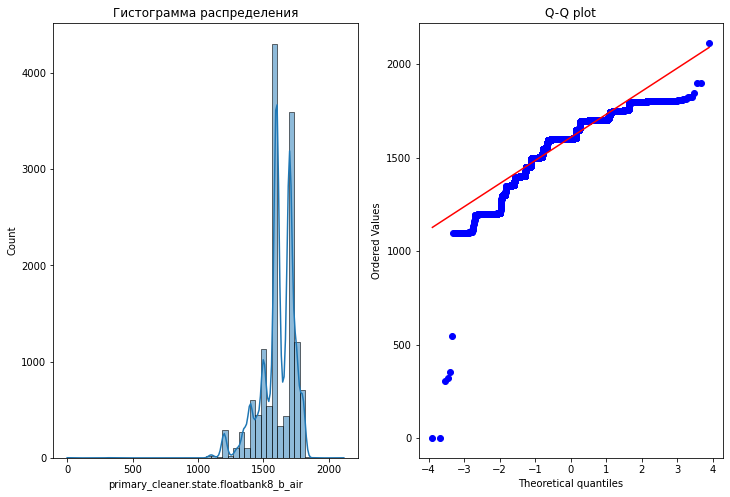

fin: 0.1268895689031085 rou: 0.10956218629313363

primary_cleaner.state.floatbank8_b_level


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


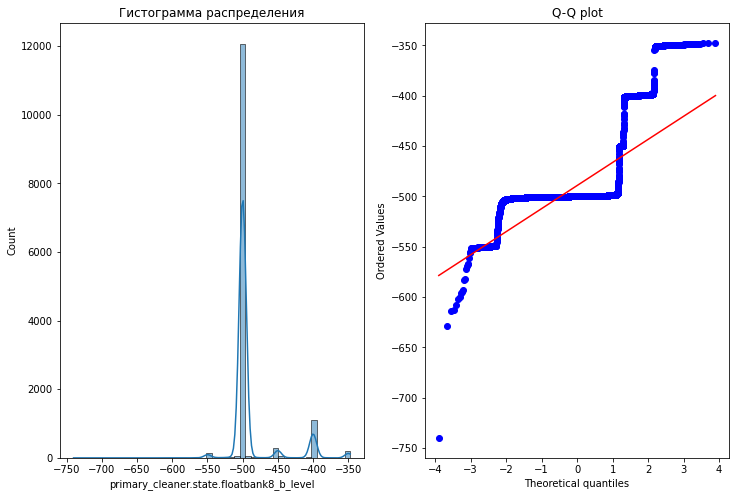

fin: 0.05265100775556309 rou: 0.03872671646810686

primary_cleaner.state.floatbank8_c_air


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


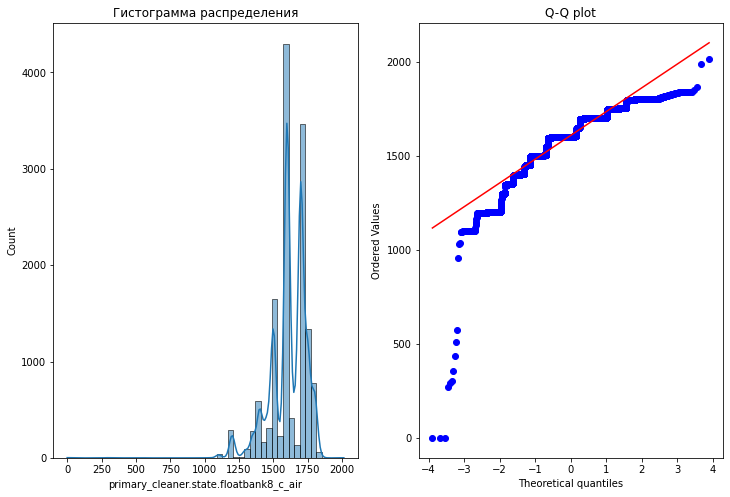

fin: 0.11404824802718816 rou: 0.10399012621980017

primary_cleaner.state.floatbank8_c_level

primary_cleaner.state.floatbank8_d_air


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


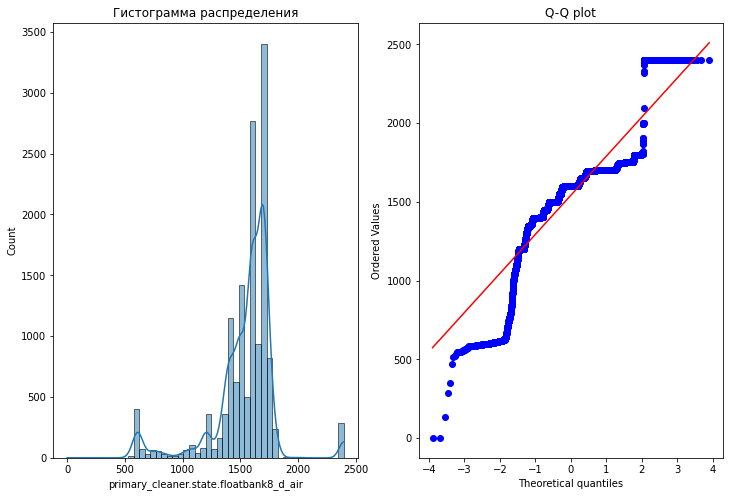

fin: 0.06806377552682001 rou: 0.03278930415473025

primary_cleaner.state.floatbank8_d_level

rougher.input.feed_ag


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


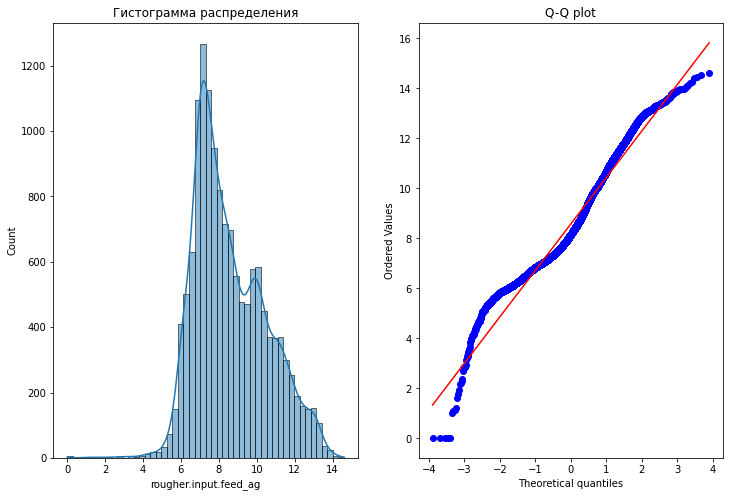

fin: 0.28682321795924265 rou: 0.1846245657643635

rougher.input.feed_pb


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


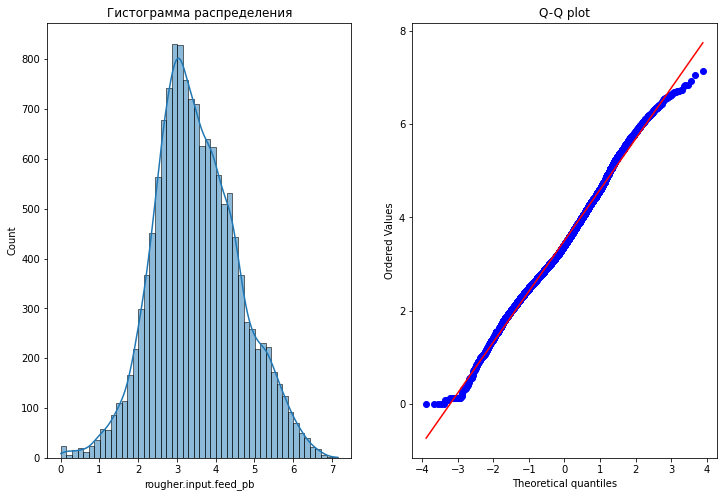

fin: 0.1880558965439661 rou: 0.18503538537801645

rougher.input.feed_rate


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


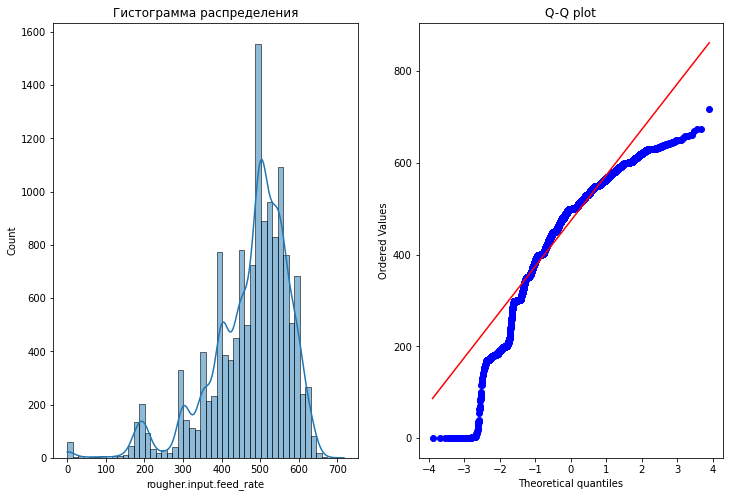

fin: 0.173657972872654 rou: 0.100789711003781

rougher.input.feed_size

rougher.input.feed_sol


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


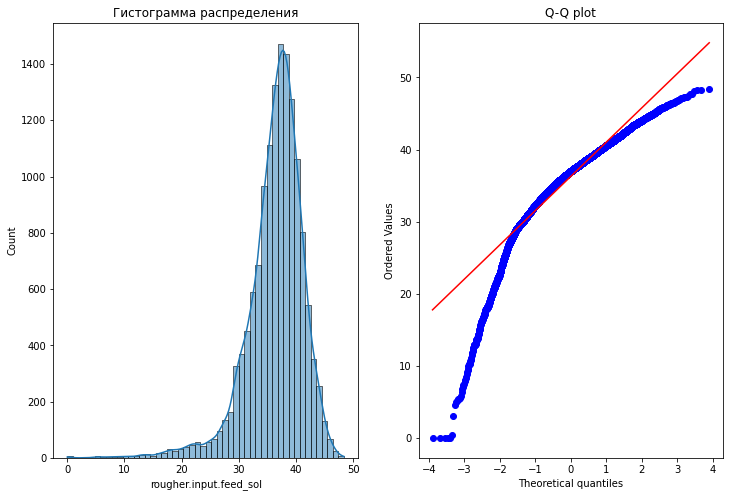

fin: 0.2518049460984159 rou: 0.19915712576809091

rougher.input.feed_au


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


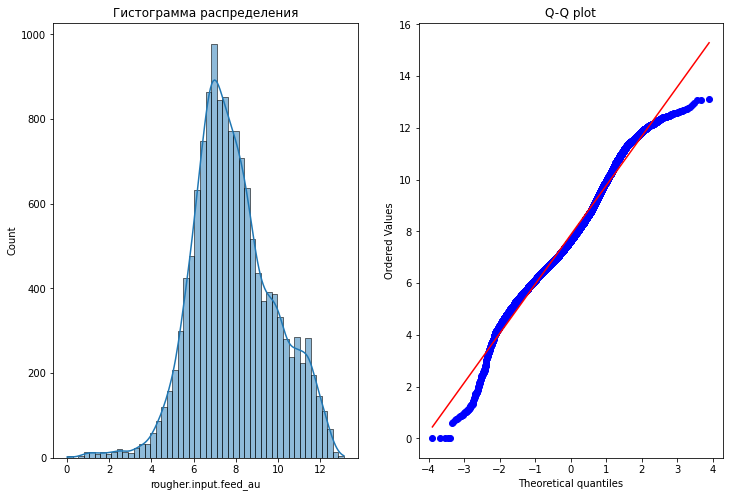

fin: 0.29534270415009084 rou: 0.18381419912197233

rougher.input.floatbank10_sulfate


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


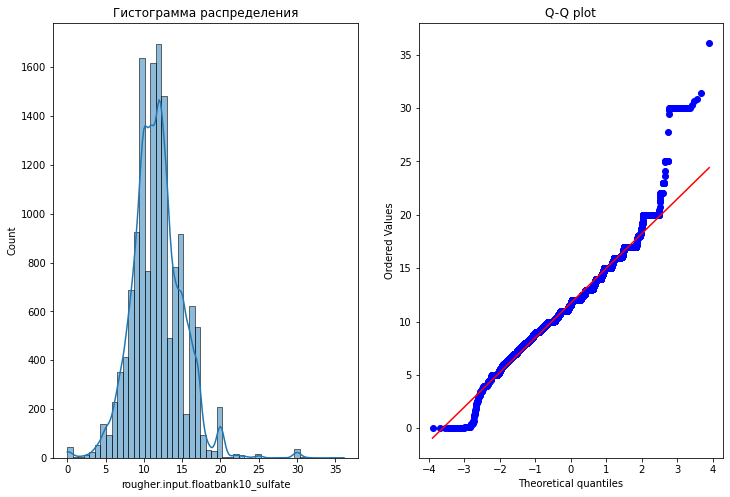

fin: 0.0612557814049299 rou: -0.014018495696481203

rougher.input.floatbank10_xanthate


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


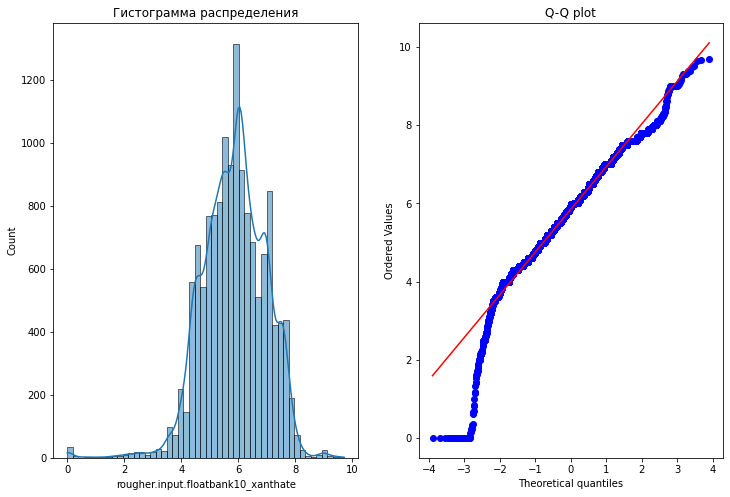

fin: 0.32466892131730224 rou: 0.2445793154350138

rougher.input.floatbank11_sulfate


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


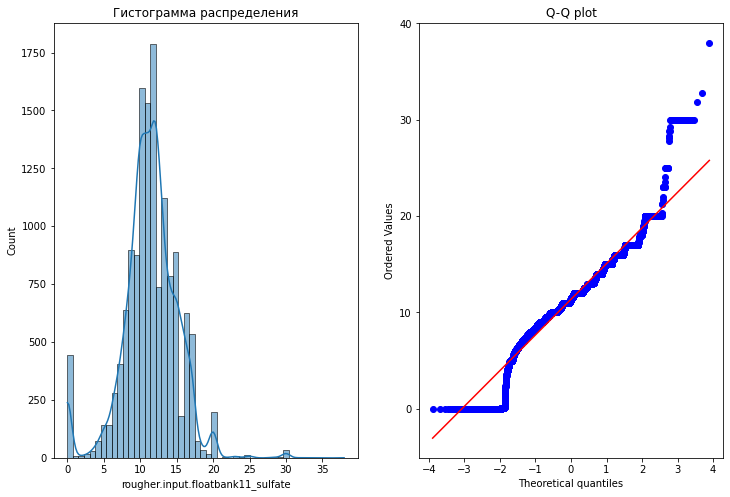

fin: 0.07879486802399173 rou: -0.0008799480710923324

rougher.input.floatbank11_xanthate


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


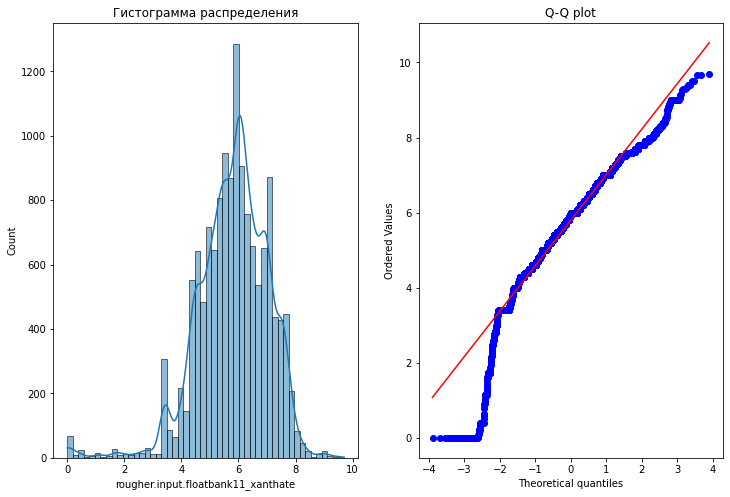

fin: 0.3111899320109402 rou: 0.22812996480219075

rougher.state.floatbank10_a_air


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


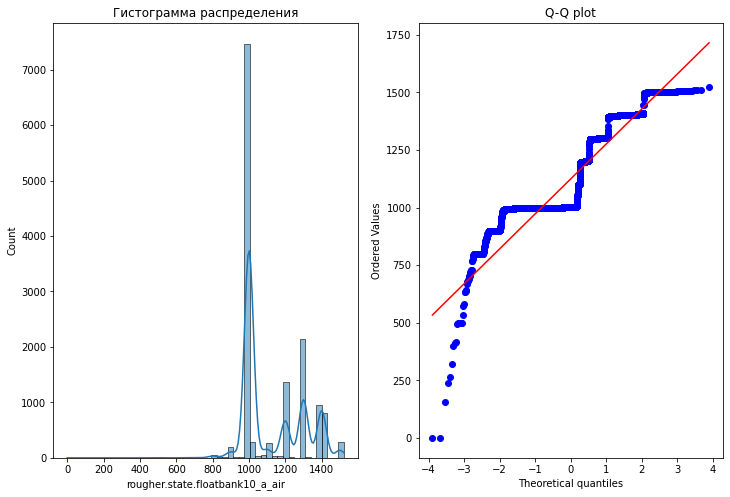

fin: 0.18322259240779265 rou: 0.14958417359750434

rougher.state.floatbank10_a_level


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


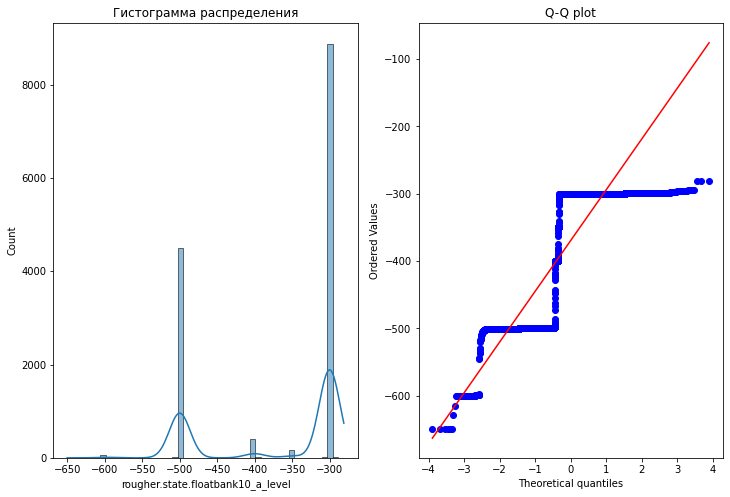

fin: 0.06536974503039622 rou: 0.11778094224680959

rougher.state.floatbank10_b_air


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


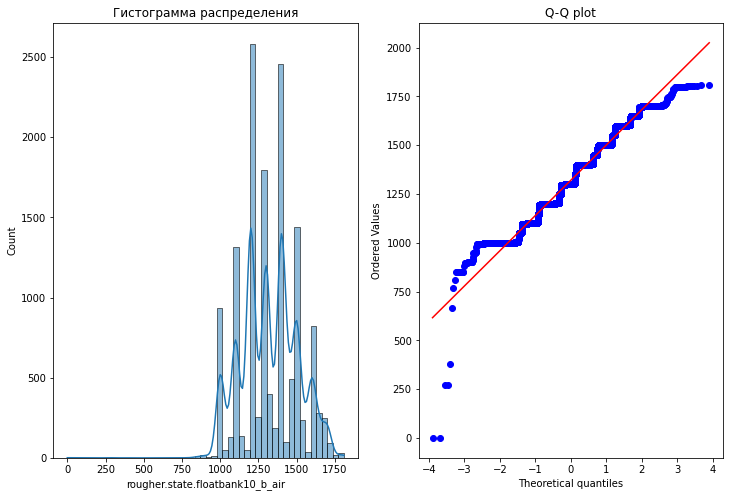

fin: -0.1196162317235902 rou: -0.06394246075465833

rougher.state.floatbank10_b_level


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


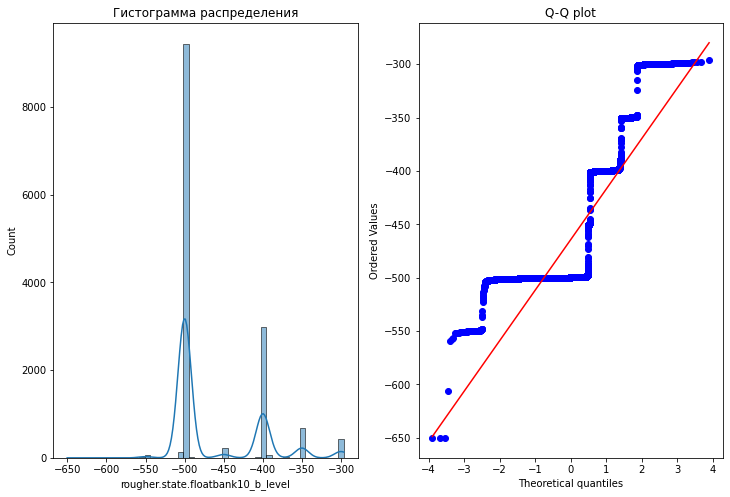

fin: -0.06881556097968447 rou: -0.05611717704645016

rougher.state.floatbank10_c_air


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


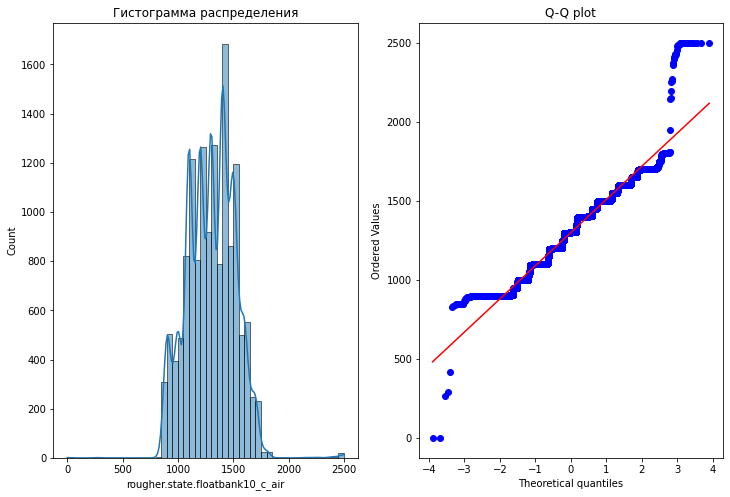

fin: -0.14931377735236792 rou: -0.08989993140222664

rougher.state.floatbank10_c_level


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


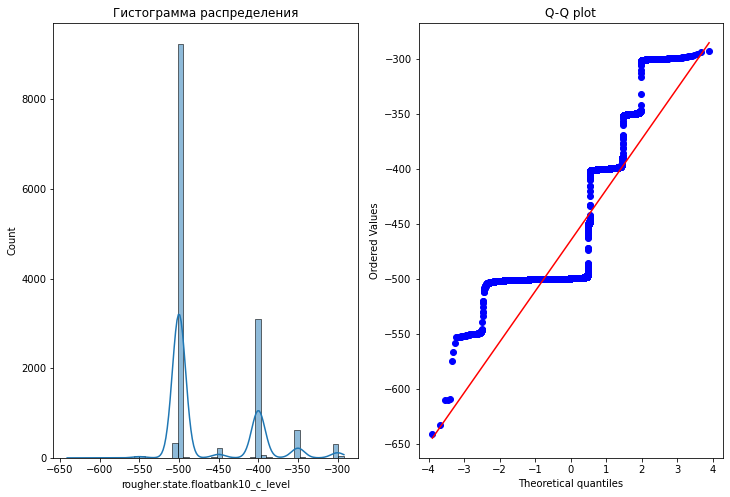

fin: -0.0779487281944982 rou: -0.05731501164504251

rougher.state.floatbank10_d_air


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


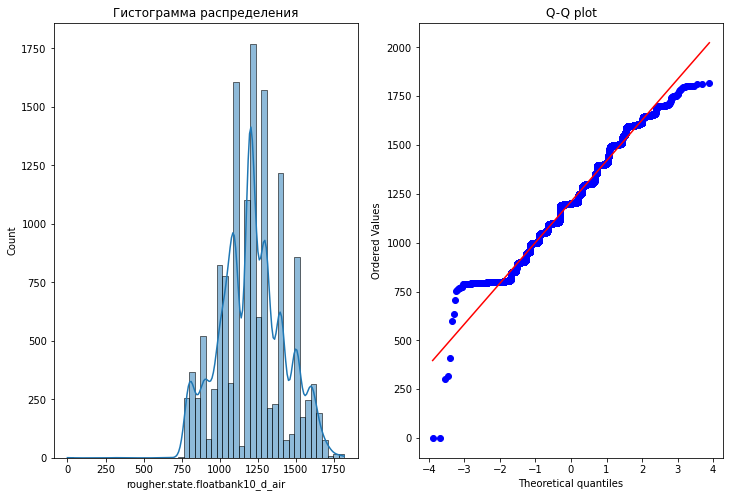

fin: -0.1448918747089725 rou: -0.08606423908992986

rougher.state.floatbank10_d_level


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


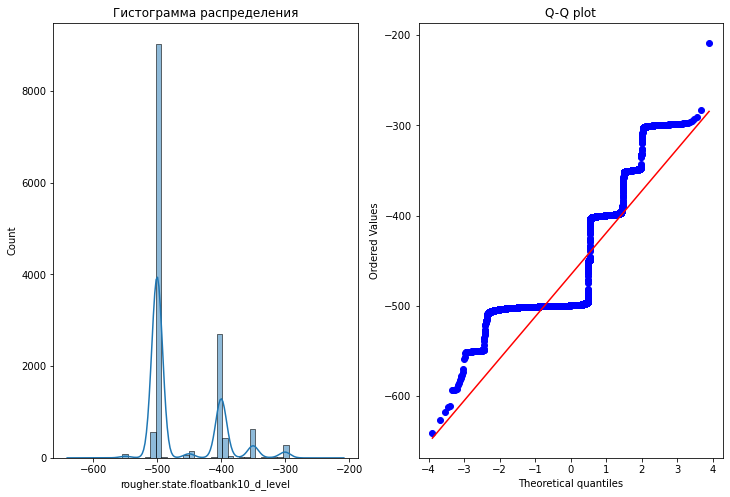

fin: -0.07214071798112444 rou: -0.054905011492780806

rougher.state.floatbank10_e_air


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


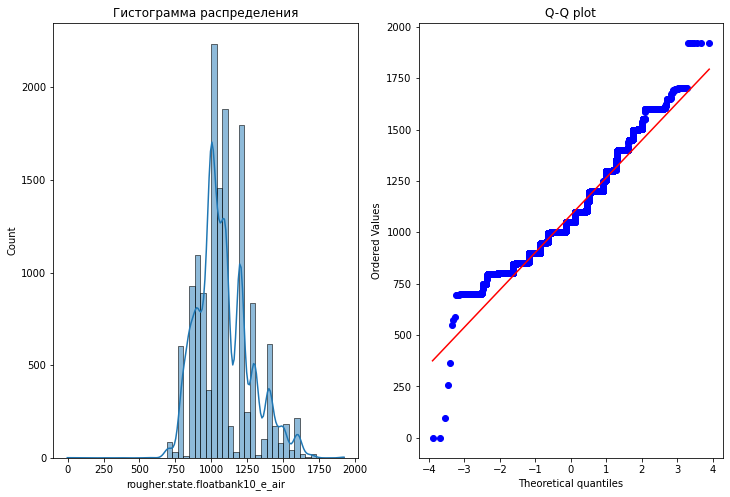

fin: -0.1097661935452094 rou: -0.0635917127191244

rougher.state.floatbank10_e_level


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


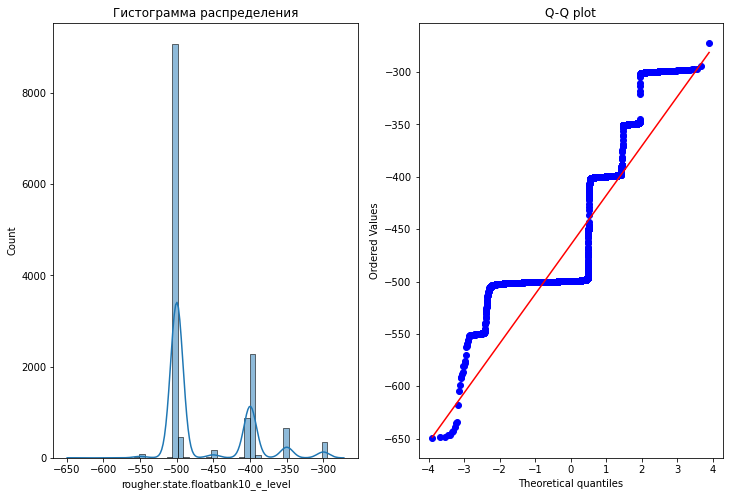

fin: -0.06157724873612507 rou: -0.043263418676352944

rougher.state.floatbank10_f_air


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


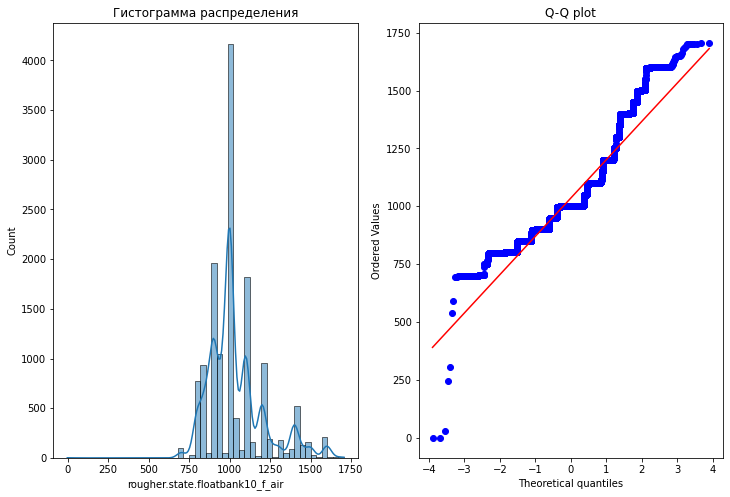

fin: -0.0828522104787682 rou: -0.034992954431702895

rougher.state.floatbank10_f_level


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


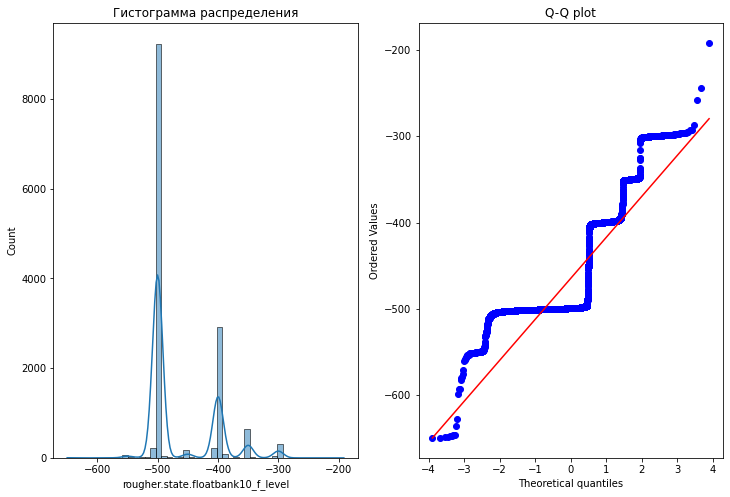

fin: -0.05678017112038045 rou: -0.040918768598590886

secondary_cleaner.state.floatbank2_a_air


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


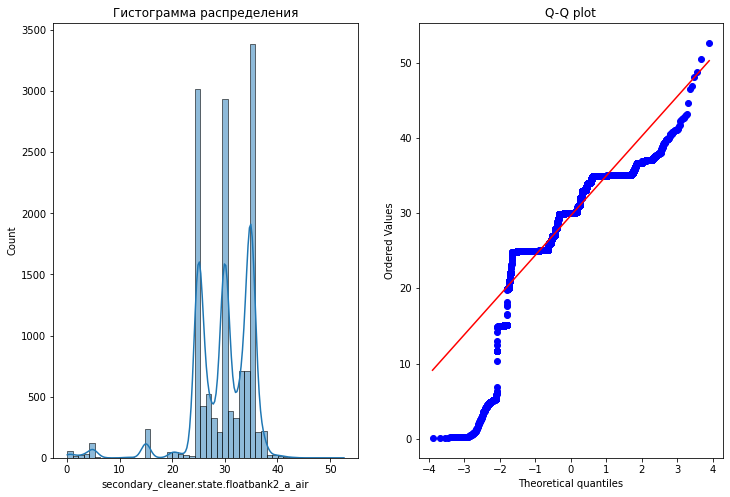

fin: 0.10686002745606538 rou: 0.1269339773586034

secondary_cleaner.state.floatbank2_a_level

secondary_cleaner.state.floatbank2_b_air


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


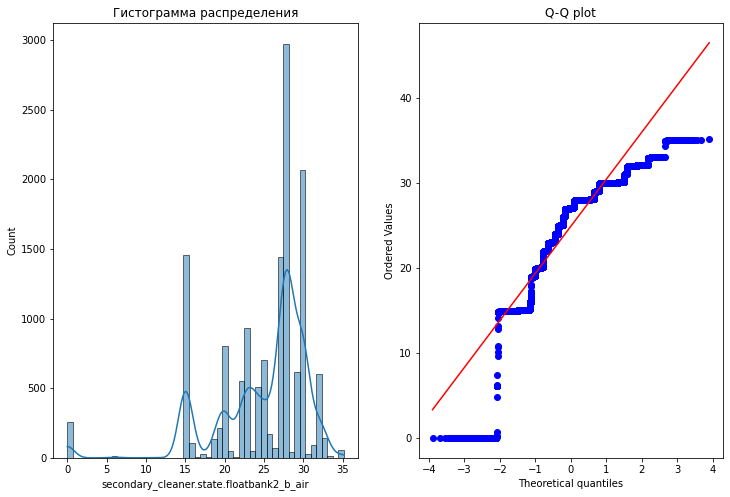

fin: 0.11432233879516211 rou: 0.1474894409403429

secondary_cleaner.state.floatbank2_b_level

secondary_cleaner.state.floatbank3_a_air


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


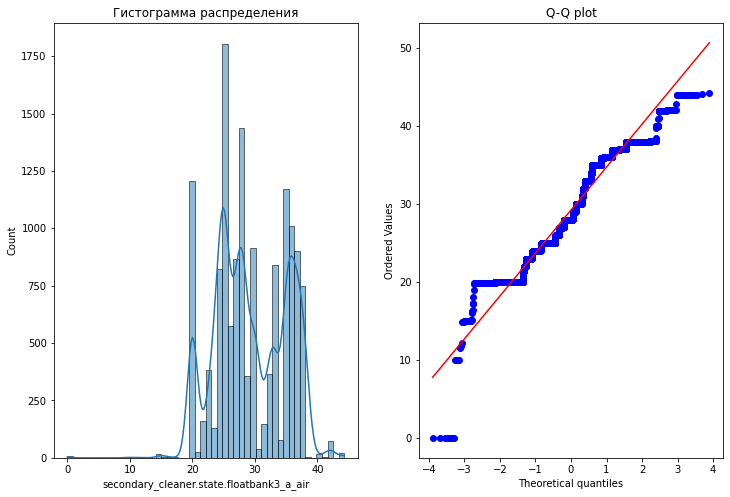

fin: 0.1476012299067933 rou: 0.16209146351393736

secondary_cleaner.state.floatbank3_a_level

secondary_cleaner.state.floatbank3_b_air


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


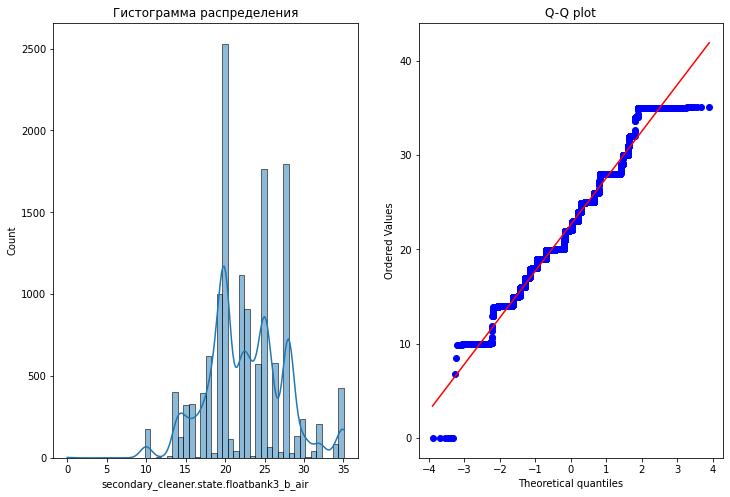

fin: 0.06548367652335164 rou: 0.09321405321499796

secondary_cleaner.state.floatbank3_b_level

secondary_cleaner.state.floatbank4_a_air


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


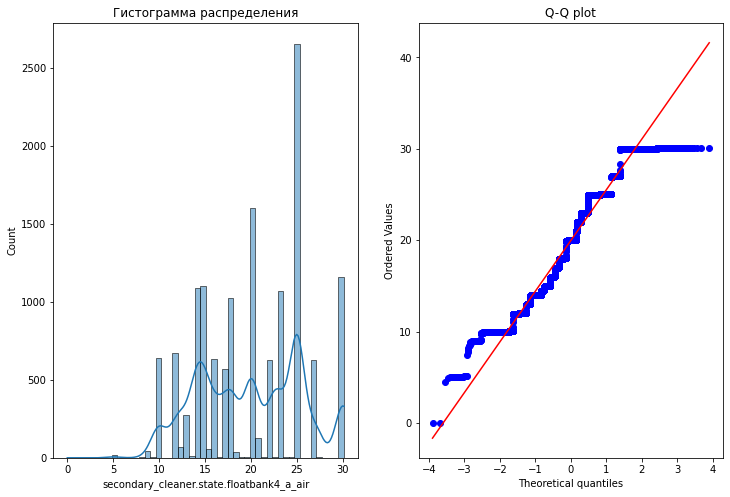

fin: 0.1685938421485167 rou: 0.21211161819633265

secondary_cleaner.state.floatbank4_a_level

secondary_cleaner.state.floatbank4_b_air


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


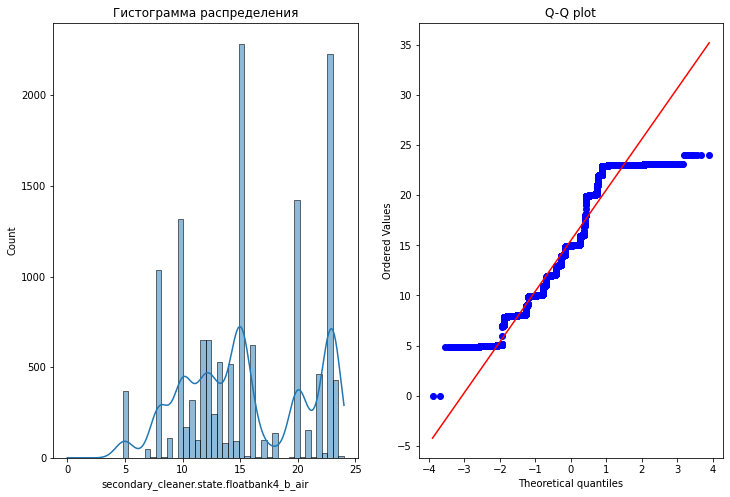

fin: 0.15853048660158803 rou: 0.2276332232607428

secondary_cleaner.state.floatbank4_b_level


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


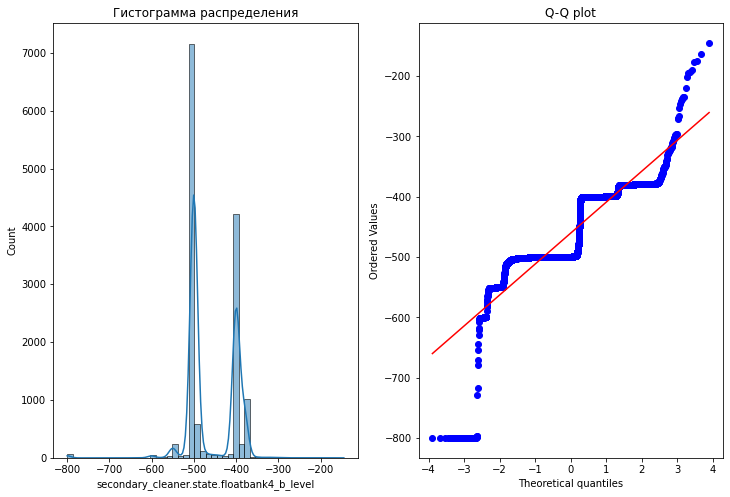

fin: -0.05002845096635944 rou: -0.035318731254816424

secondary_cleaner.state.floatbank5_a_air


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


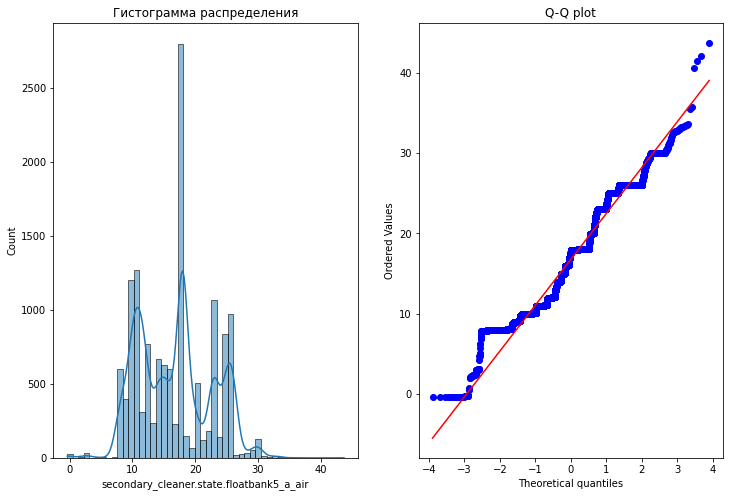

fin: 0.06697397318272813 rou: 0.1449696812006444

secondary_cleaner.state.floatbank5_a_level

secondary_cleaner.state.floatbank5_b_air


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


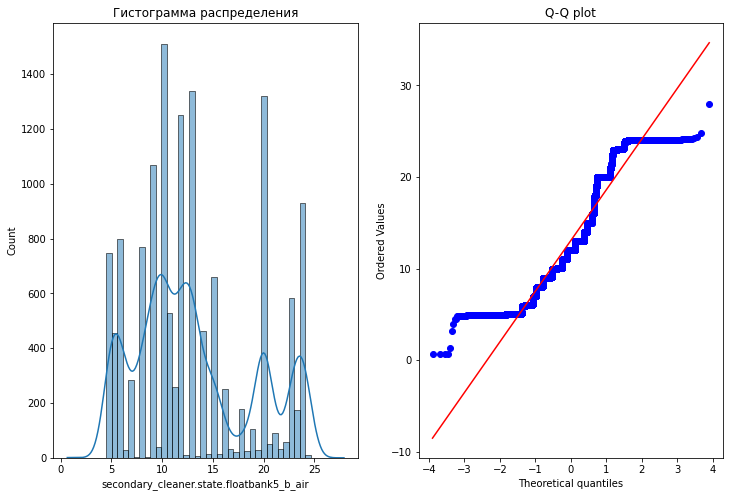

fin: 0.05198746027559378 rou: 0.14422537993337795

secondary_cleaner.state.floatbank5_b_level

secondary_cleaner.state.floatbank6_a_air

secondary_cleaner.state.floatbank6_a_level



In [ ]:
REAL_FIN_COL = []
REAL_ROU_COL = []
for column in data_for_analisys.columns:
    print(column)
    fin_corr = data_full[[column, 'final.output.recovery']].corr().iloc[0, 1]
    rou_corr = data_full[[column, 'rougher.output.recovery']].corr().iloc[0, 1]
    if abs(fin_corr) > 0.05:
        REAL_FIN_COL.append(column)
    if abs(rou_corr) > 0.05:
        REAL_ROU_COL.append(column)
    if abs(fin_corr) > 0.05 or abs(rou_corr) > 0.05:
        show_hist_and_qqplot(data_for_analisys, column)
        print(f"fin: {fin_corr}", f"rou: {rou_corr}")
    print()

Видно, что гистограммы признаков `primary_cleaner.input.depressant, primary_cleaner.input.xanthate, primary_cleaner.state.floatbank8_a_air, primary_cleaner.state.floatbank8_b_air, primary_cleaner.state.floatbank8_c_air, primary_cleaner.state.floatbank8_d_air, rougher.input.feed_rate, rougher.input.feed_sol, rougher.input.floatbank10_xanthate, rougher.input.floatbank11_sulfate, rougher.input.floatbank11_xanthate` зажаты либо к левому, либо к правому краю. Воспользуемся преобразованием бокса-кокса. Я буду использовать частный случай логорифмирование.

Признаки `primary_cleaner.state.floatbank8_b_level, primary_cleaner.state.floatbank8_d_air, rougher.state.floatbank10_a_air, rougher.state.floatbank10_a_level, rougher.state.floatbank10_b_level, rougher.state.floatbank10_c_level, rougher.state.floatbank10_d_level, rougher.state.floatbank10_e_level, rougher.state.floatbank10_f_level, secondary_cleaner.state.floatbank4_b_level` очень слабо коррелируют с таргетом, на q-q plot большое количество ступенек, распределение не похоже на нормальное распределение, в дальнейшем попробуем нарезать эти признаки на интервалы, превратив их в категориальные

/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


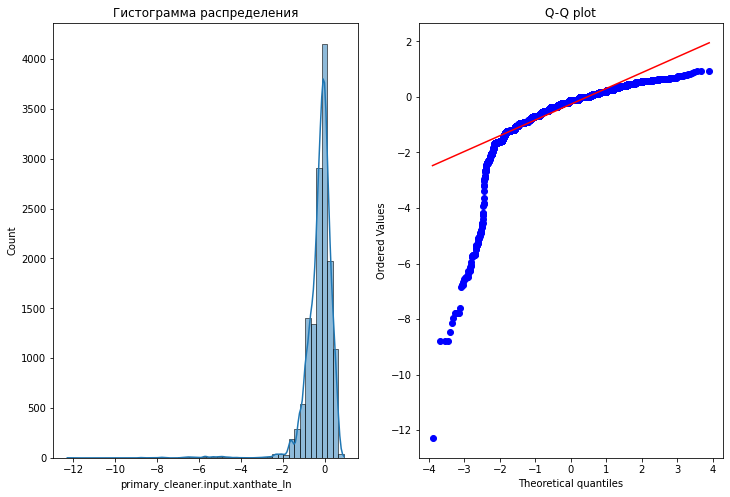

fin: -0.041338496915324076 rou: -0.07290050264323823


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


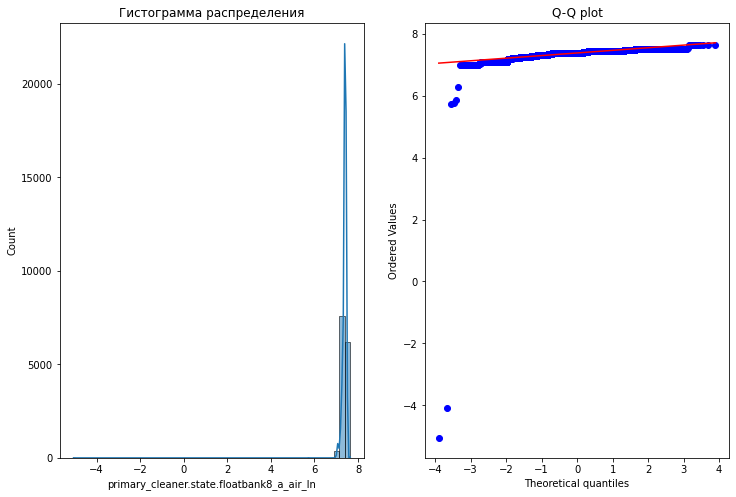

fin: 0.060273275505871325 rou: 0.05979005025954315


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


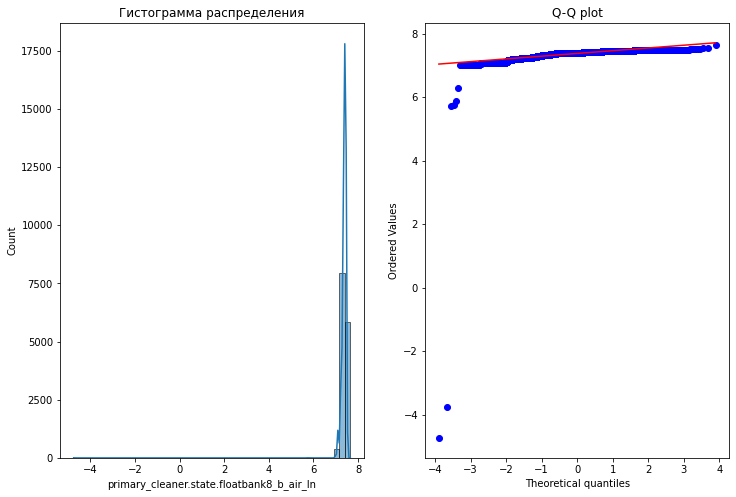

fin: 0.054345793009145674 rou: 0.05044779347754587


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


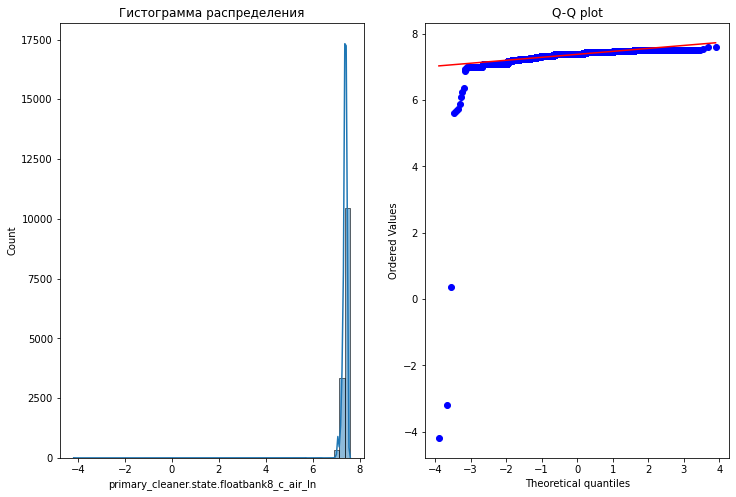

fin: 0.07072575966933557 rou: 0.06435154401117216


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


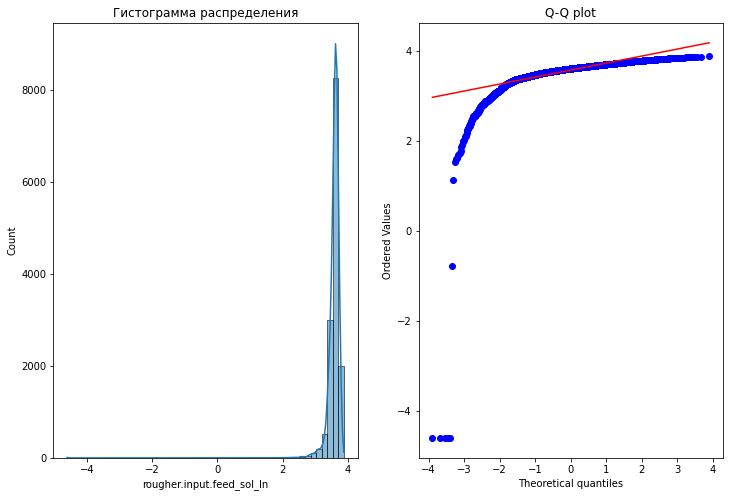

fin: 0.06937787149077694 rou: 0.059649067450608245


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


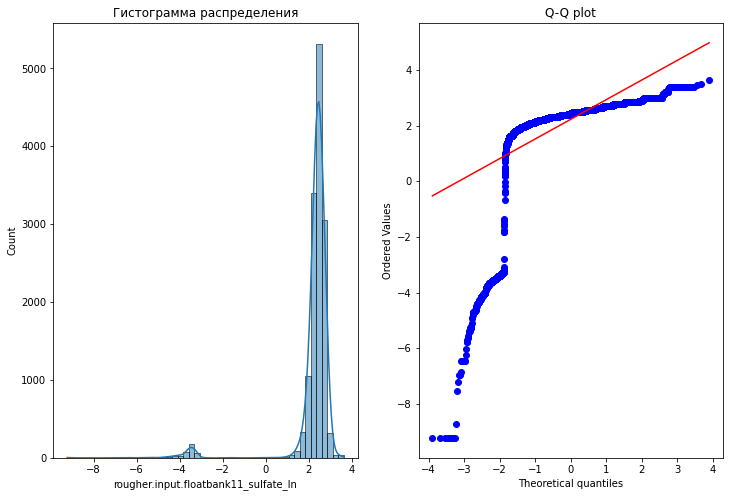

fin: 0.0527445696512702 rou: 0.0519258160406979


In [ ]:
list_for_ln = ['primary_cleaner.input.depressant', 'primary_cleaner.input.xanthate',
               'primary_cleaner.state.floatbank8_a_air', 'primary_cleaner.state.floatbank8_b_air',
               'primary_cleaner.state.floatbank8_c_air', 'primary_cleaner.state.floatbank8_d_air',
               'rougher.input.feed_rate', 'rougher.input.feed_sol', 'rougher.input.floatbank10_xanthate',
               'rougher.input.floatbank11_sulfate', 'rougher.input.floatbank11_xanthate']

for column in list_for_ln:
    data_for_analisys[f'{column}_ln'] = np.log(data_for_analisys[column])
    fin_corr = pd.concat([data_full[['final.output.recovery']], data_for_analisys[[f'{column}_ln']]], axis=1).corr().iloc[0, 1]
    rou_corr = pd.concat([data_full[['rougher.output.recovery']], data_for_analisys[[f'{column}_ln']]], axis=1).corr().iloc[0, 1]
    if abs(fin_corr) > 0.05 or abs(rou_corr) > 0.05:
        show_hist_and_qqplot(data_for_analisys, f'{column}_ln')
        print(f"fin: {fin_corr}", f"rou: {rou_corr}")

Логарифмирование улучшело показатели корреляции для `rougher.input.floatbank11_sulfate_ln и primary_cleaner.input.depressant_ln`

In [ ]:
REAL_FIN_COL.append('rougher.input.floatbank11_sulfate_ln')
REAL_FIN_COL.append('primary_cleaner.input.depressant_ln')
REAL_ROU_COL.append('rougher.input.floatbank11_sulfate_ln')
REAL_ROU_COL.append('primary_cleaner.input.depressant_ln')

Посмотрим как меняется концетрация метталов по отдельности на каждом из этапов очистки

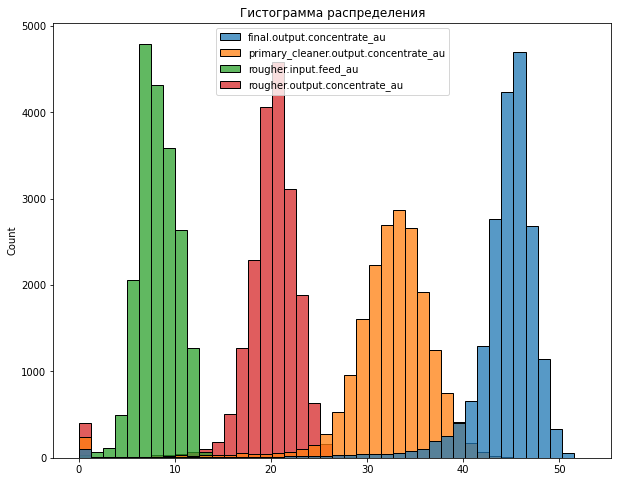

In [ ]:
list_for_an = data_full.loc[:, (data_full.columns.str.contains('output.concentrate_au')) | \
                            (data_full.columns.str.contains('rougher.input.feed_au'))].columns

plt.figure(figsize=(10, 8))
ax = sns.histplot(data_full[list_for_an])
ax.set_title('Гистограмма распределения')
plt.show()

In [ ]:
data_full[list_for_an].mean()

final.output.concentrate_au              44.076513
primary_cleaner.output.concentrate_au    32.119400
rougher.input.feed_au                     8.266097
rougher.output.concentrate_au            19.772000
dtype: float64

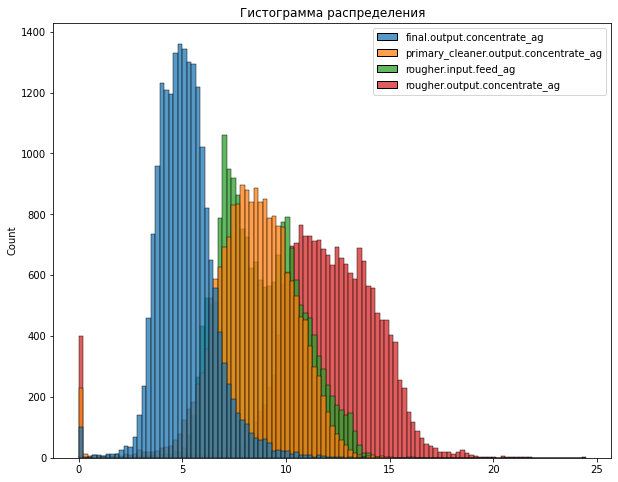

In [ ]:
list_for_an = data_full.loc[:, (data_full.columns.str.contains('output.concentrate_ag')) | \
                            (data_full.columns.str.contains('rougher.input.feed_ag'))].columns

plt.figure(figsize=(10, 8))
ax = sns.histplot(data_full[list_for_an])
ax.set_title('Гистограмма распределения')
plt.show()

In [ ]:
data_full[list_for_an].mean()

final.output.concentrate_ag               5.168387
primary_cleaner.output.concentrate_ag     8.442408
rougher.input.feed_ag                     8.794927
rougher.output.concentrate_ag            11.994759
dtype: float64

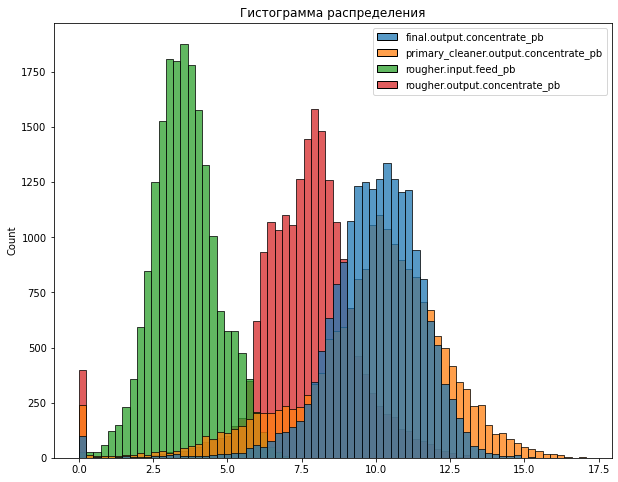

In [ ]:
list_for_an = data_full.loc[:, (data_full.columns.str.contains('output.concentrate_pb')) | \
                            (data_full.columns.str.contains('rougher.input.feed_pb'))].columns

plt.figure(figsize=(10, 8))
ax = sns.histplot(data_full[list_for_an])
ax.set_title('Гистограмма распределения')
plt.show()

In [ ]:
data_full[list_for_an].mean()

final.output.concentrate_pb              9.978821
primary_cleaner.output.concentrate_pb    9.810317
rougher.input.feed_pb                    3.585096
rougher.output.concentrate_pb            7.606272
dtype: float64

Можно заметить, что распределение содержания металов на всех этапах похоже на нормальное. Есть небольшие скопления нулей на первом этапе, но с каждым следующим их количество уменьшается. Можно заметить, что содержание `pd` и `au` увеличивается, а содежание `ag` уменьшается

Проверим распределения гранул сырья на обучающей выборке и тестовой

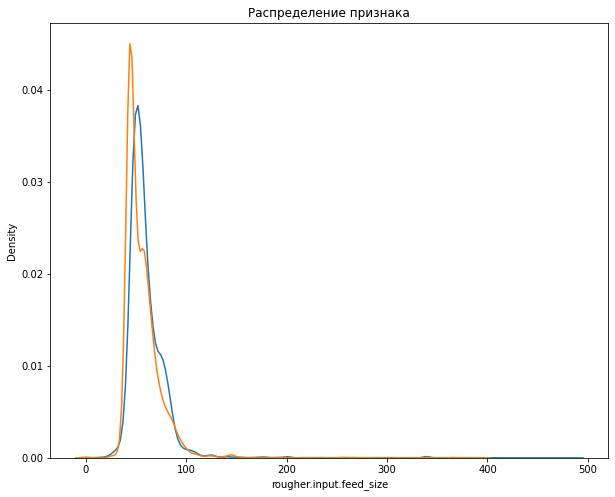

In [ ]:
plt.figure(figsize=(10, 8))
sns.kdeplot(data_train['rougher.input.feed_size'])
sns.kdeplot(data_test['rougher.input.feed_size']).set_title('Распределение признака')
plt.show()

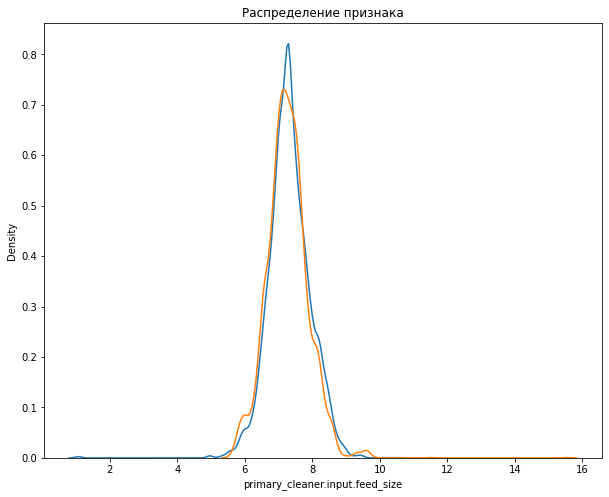

In [ ]:
plt.figure(figsize=(10, 8))
sns.kdeplot(data_train['primary_cleaner.input.feed_size'])
sns.kdeplot(data_test['primary_cleaner.input.feed_size']).set_title('Распределение признака')
plt.show()

Распределения гранул сырья на тренировочной и тестовой почти не отличаются: распределения похожи на нормальное, основная масса значений лежит в одинаковых интервалах

Посмотрим на суммарную концентрацию всех веществ на разных стадиях

In [ ]:
list_for_an = data_full.loc[:, (data_full.columns.str.contains('output.concentrate_au')) | \
                            (data_full.columns.str.contains('output.concentrate_ag')) | \
                             (data_full.columns.str.contains('output.concentrate_pb')) | \
                            (data_full.columns.str.contains('rougher.input.feed_au')) | \
                            (data_full.columns.str.contains('rougher.input.feed_ag')) | \
                            (data_full.columns.str.contains('rougher.input.feed_pb'))].columns

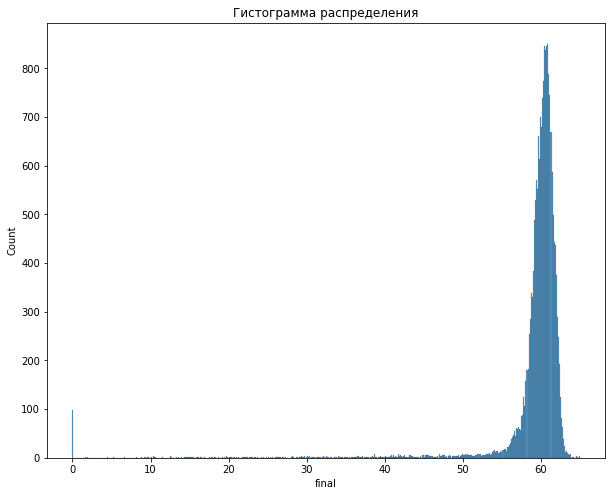

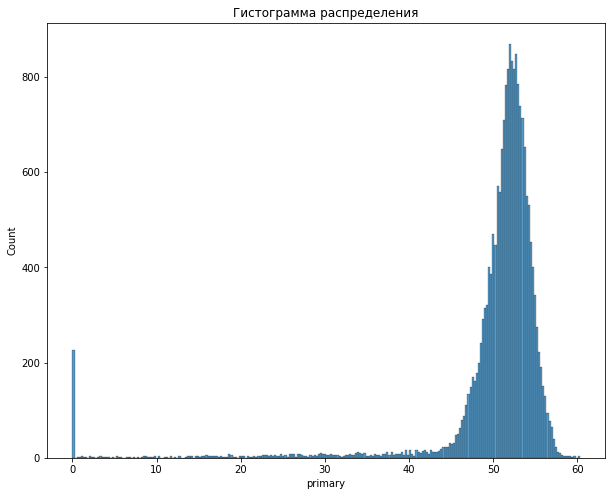

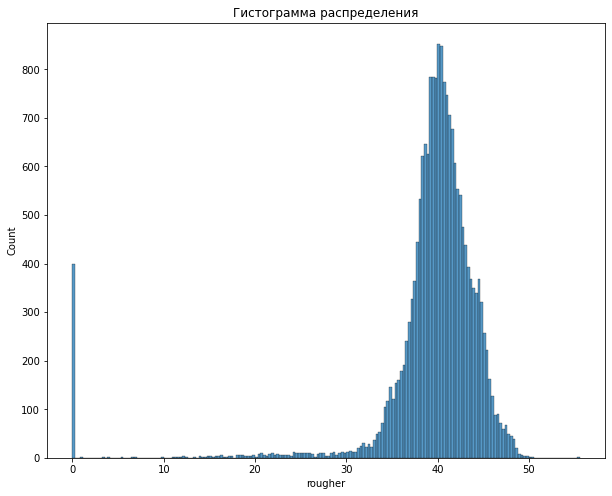

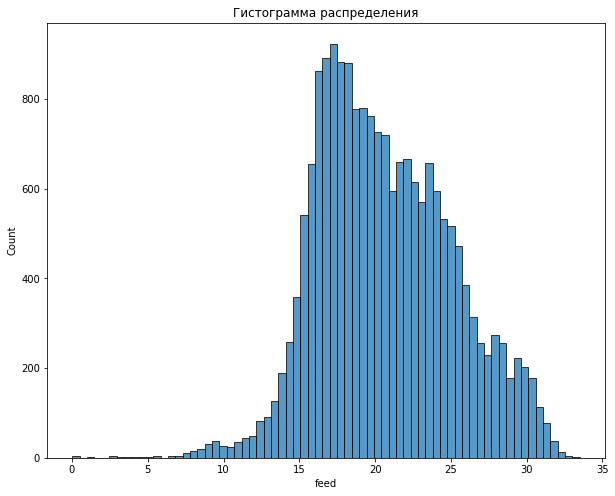

In [ ]:
final, primary = data_full[list_for_an[:3]].sum(axis=1), data_full[list_for_an[3:6]].sum(axis=1)
rougher, feed = data_full[list_for_an[9:]].sum(axis=1), data_full[list_for_an[6:9]].sum(axis=1)

plt.figure(figsize=(10, 8))
ax = sns.histplot(final)
ax.set_title('Гистограмма распределения')
ax.set_xlabel('final')
plt.show()

plt.figure(figsize=(10, 8))
ax = sns.histplot(primary)
ax.set_title('Гистограмма распределения')
ax.set_xlabel('primary')
plt.show()

plt.figure(figsize=(10, 8))
ax = sns.histplot(rougher)
ax.set_title('Гистограмма распределения')
ax.set_xlabel('rougher')
plt.show()

plt.figure(figsize=(10, 8))
ax = sns.histplot(feed)
ax.set_title('Гистограмма распределения')
ax.set_xlabel('feed')
plt.show()

In [ ]:
print(f'final: {final.mean()}', f'primary: {primary.mean()}', f'rougher: {rougher.mean()}', f'feed: {feed.mean()}', sep='\n')

final: 59.22372129365595
primary: 50.372125024905706
rougher: 39.37303181255475
feed: 20.646120463989536


Можем заметить, что на каждом этапе обработки, концетрация металлов увеличивается

Как было замечено ранее, в левой части графиков есть скопление нулей. Они являются аномалии, поэтому адлим их из обучающей выборки

In [ ]:
list_for_an

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_au', 'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_au', 'rougher.input.feed_size',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb',
       'rougher.output.concentrate_au'],
      dtype='object')

In [ ]:
data_train.shape

(14149, 87)

In [ ]:
for column in list_for_an:
    try:
        ind = data_train.loc[data_train[column] == 0].index
        data_train.drop(ind, inplace=True)
    except:
        pass
data_train.shape

(13720, 87)

Промежуточный вывод: были проанализированы данные, сделаны гипотезы по улучшению данных, удалены аномалии

## Построение модели

Добавим таргеты в тестовую выборку

In [ ]:
data_test = data_test.merge(data_full[['date', 'final.output.recovery', 'rougher.output.recovery']], on='date')
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5290 entries, 0 to 5289
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5290 non-null   float64
 2   primary_cleaner.input.depressant            5290 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

Разделим тренировочный датасет на признаки и таргеты

In [ ]:
y = data_train[['final.output.recovery', 'rougher.output.recovery']]

In [ ]:
X, y_fin, y_rou = data_train.drop(columns_not_in_test, axis=1), y['final.output.recovery'], y['rougher.output.recovery']

Уберём признак `date`

In [ ]:
data_test.drop('date', axis=1, inplace=True)
X.drop('date', axis=1, inplace=True)

In [ ]:
X['rougher.input.floatbank11_sulfate_ln'] = np.log(X['rougher.input.floatbank11_sulfate'])
X['primary_cleaner.input.depressant_ln'] = np.log(X['primary_cleaner.input.depressant'])

/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Проверим, есть бесконечности в наших новых данных

In [ ]:
all(np.isfinite(X['rougher.input.floatbank11_sulfate_ln']))

True

In [ ]:
all(np.isfinite(X['primary_cleaner.input.depressant_ln']))

False

Заменим эти значения приближенными

In [ ]:
X.loc[np.isfinite(X['primary_cleaner.input.depressant_ln']) == False, 'primary_cleaner.input.depressant_ln'] = np.log(1e-100)
all(np.isfinite(X['primary_cleaner.input.depressant_ln']))

True

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13720 entries, 0 to 14148
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               13720 non-null  float64
 1   primary_cleaner.input.depressant            13720 non-null  float64
 2   primary_cleaner.input.feed_size             13720 non-null  float64
 3   primary_cleaner.input.xanthate              13720 non-null  float64
 4   primary_cleaner.state.floatbank8_a_air      13720 non-null  float64
 5   primary_cleaner.state.floatbank8_a_level    13720 non-null  float64
 6   primary_cleaner.state.floatbank8_b_air      13720 non-null  float64
 7   primary_cleaner.state.floatbank8_b_level    13720 non-null  float64
 8   primary_cleaner.state.floatbank8_c_air      13720 non-null  float64
 9   primary_cleaner.state.floatbank8_c_level    13720 non-null  float64
 10  primary_cl

### sMAPE

Реализуем нужную метрику

In [ ]:
def sMAPE(true, pred):
    return np.mean((abs(true - pred) / ((abs(true) + abs(pred)) / 2))) * 100

In [ ]:
def itog_sMAPE(rou, fin):
    return 0.25 * rou + 0.75 * fin

Напишем функцию для кросвалидации

In [ ]:
def cross_val_score(model, X, y, n_splits=5):
    skf = KFold(n_splits=n_splits, shuffle=True)
    list_with_smape = []
    for train_index, val_index in tqdm(skf.split(X, y)):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model.fit(X_train, y_train)
        smape = sMAPE(y_val, model.predict(X_val))
        list_with_smape.append(smape)
    return np.array(list_with_smape)

Создадим пайплайн для данных

In [ ]:
class Pipeline:
    def __init__(self, estimator=Ridge(random_state=SEED), real_features=None, cat_features=None, bin_features=None, n_bins=0, power=1):
        self.real_features = real_features
        self.cat_features = cat_features
        self.bin_features = bin_features
        # preprocessing
        self.onehot_encoder = OneHotEncoder(drop='first', dtype='int', handle_unknown='ignore')
        self.bin_encoder = KBinsDiscretizer(n_bins=n_bins, encode='onehot-dense', strategy='uniform')
        self.std_scaler = StandardScaler()
        self.poly = PolynomialFeatures(power)
        #model
        self.model = estimator

    def fit(self, X, y, return_X_result=False):
        X_result = []

        if self.bin_features:
            X_bin = self.bin_encoder.fit_transform(X[self.bin_features])
            X_result.append(X_bin)

        if self.cat_features:
            X_cat = self.onehot_encoder.fit_transform(X[self.cat_features])
            X_result.append(X_cat.toarray())

        if self.real_features:
            X_real = self.std_scaler.fit_transform(self.poly.fit_transform(X[self.real_features])[:, 1:])
            X_result.append(X_real)

        X_result = np.hstack(X_result)
        self.model.fit(X_result, y)
        return X_result.shape if return_X_result else None

    def predict(self, X):
        X_result = []

        if self.bin_features:
            X_bin = self.bin_encoder.transform(X[self.bin_features])
            X_result.append(X_bin)

        if self.cat_features:
            X_cat = self.onehot_encoder.transform(X[self.cat_features])
            X_result.append(X_cat.toarray())

        if self.real_features:
            X_real = self.std_scaler.transform(self.poly.transform(X[self.real_features])[:, 1:])
            X_result.append(X_real)

        X_result = np.hstack(X_result)
        return self.model.predict(X_result)

## Первые модели

Обучим данные на признаках без преобразований

### Ridge


In [ ]:
model = Ridge(random_state=SEED)
g = cross_val_score(Pipeline(estimator=model, real_features=REAL_FIN_COL[:-2],
                             cat_features=CAT_COL), X, y_fin, n_splits=N_SPLITS)
fin = np.mean(g)
fin

7it [00:01,  5.76it/s]


8.12164194497276

In [ ]:
model = Ridge(random_state=SEED)
g = cross_val_score(Pipeline(estimator=model, real_features=REAL_ROU_COL[:-2],
                             cat_features=CAT_COL), X, y_rou, n_splits=N_SPLITS)
rou = np.mean(g)
rou

7it [00:01,  5.75it/s]


4.96188808305659

In [ ]:
# итоговая
itog_sMAPE(rou, fin)

7.331703479493718

### RandomForest

In [ ]:
model = RandomForestRegressor(random_state=SEED)
g = cross_val_score(Pipeline(estimator=model, real_features=REAL_FIN_COL[:-2],
                             cat_features=CAT_COL), X, y_fin, n_splits=N_SPLITS)
fin = np.mean(g)
fin

7it [04:19, 37.10s/it]


5.587831986882152

In [ ]:
model = RandomForestRegressor(random_state=SEED)
g = cross_val_score(Pipeline(estimator=model, real_features=REAL_ROU_COL[:-2],
                             cat_features=CAT_COL), X, y_rou, n_splits=N_SPLITS)
rou = np.mean(g)
rou

7it [02:56, 25.28s/it]


2.5058460449024302

In [ ]:
# итоговая
itog_sMAPE(rou, fin)

4.817335501387222

### Gradient Boosting

In [ ]:
model = CatBoostRegressor(verbose=0, random_seed=SEED)
g = cross_val_score(Pipeline(estimator=model, real_features=REAL_FIN_COL[:-2],
                             cat_features=CAT_COL), X, y_fin, n_splits=N_SPLITS)
fin = np.mean(g)
fin

7it [01:21, 11.63s/it]


5.703094293582702

In [ ]:
model = CatBoostRegressor(verbose=0, random_seed=SEED)
g = cross_val_score(Pipeline(estimator=model, real_features=REAL_ROU_COL[:-2],
                             cat_features=CAT_COL), X, y_rou, n_splits=N_SPLITS)
rou = np.mean(g)
rou

7it [01:05,  9.39s/it]


2.656307630555598

In [ ]:
# итоговая
itog_sMAPE(rou, fin)

4.941397627825927

На дефолтных данных лучшей моделью является случайный лес

## Вторые модели

Попробуем убрать `rougher.input.floatbank11_sulfate`, `primary_cleaner.input.depressant` и вместо них использовать `rougher.input.floatbank11_sulfate_ln`, `primary_cleaner.input.depressant_ln`

In [ ]:
try:
    del REAL_FIN_COL[REAL_FIN_COL.index('rougher.input.floatbank11_sulfate')]
    print('Done')
except:
    print('Not in the list')
try:
    del REAL_FIN_COL[REAL_FIN_COL.index('primary_cleaner.input.depressant')]
    print('Done')
except:
    print('Not in the list')

try:
    del REAL_ROU_COL[REAL_ROU_COL.index('rougher.input.floatbank11_sulfate')]
    print('Done')
except:
    print('Not in the list')

try:
    del REAL_ROU_COL[REAL_ROU_COL.index('primary_cleaner.input.depressant')]
    print('Done')
except:
    print('Not in the list')

Done
Done
Not in the list
Done


### Ridge


In [ ]:
model = Ridge(random_state=SEED)
g = cross_val_score(Pipeline(estimator=model, real_features=REAL_FIN_COL,
                             cat_features=CAT_COL), X, y_fin, n_splits=N_SPLITS)
fin = np.mean(g)
fin

7it [00:01,  5.79it/s]


8.144405867401696

In [ ]:
model = Ridge(random_state=SEED)
g = cross_val_score(Pipeline(estimator=model, real_features=REAL_ROU_COL,
                             cat_features=CAT_COL), X, y_rou, n_splits=N_SPLITS)
rou = np.mean(g)
rou

7it [00:01,  5.38it/s]


4.949062708735835

In [ ]:
# итоговая
itog_sMAPE(rou, fin)

7.345570077735231

### RandomForest

In [ ]:
model = RandomForestRegressor(random_state=SEED)
g = cross_val_score(Pipeline(estimator=model, real_features=REAL_FIN_COL,
                             cat_features=CAT_COL), X, y_fin, n_splits=N_SPLITS)
fin = np.mean(g)
fin

7it [04:21, 37.36s/it]


5.630680176261001

In [ ]:
model = RandomForestRegressor(random_state=SEED)
g = cross_val_score(Pipeline(estimator=model, real_features=REAL_ROU_COL,
                             cat_features=CAT_COL), X, y_rou, n_splits=N_SPLITS)
rou = np.mean(g)
rou

7it [03:06, 26.70s/it]


2.498856372085164

In [ ]:
# итоговая
itog_sMAPE(rou, fin)

4.847724225217042

### Gradient Boosting

In [ ]:
model = CatBoostRegressor(verbose=0, random_state=SEED)
g = cross_val_score(Pipeline(estimator=model, real_features=REAL_FIN_COL,
                             cat_features=CAT_COL), X, y_fin, n_splits=N_SPLITS)
fin = np.mean(g)
fin

7it [01:24, 12.06s/it]


5.699200796114227

In [ ]:
model = CatBoostRegressor(verbose=0, random_state=SEED)
g = cross_val_score(Pipeline(estimator=model, real_features=REAL_ROU_COL,
                             cat_features=CAT_COL), X, y_rou, n_splits=N_SPLITS)
rou = np.mean(g)
rou

7it [01:10, 10.02s/it]


2.623145261358675

In [ ]:
# итоговая
itog_sMAPE(rou, fin)

4.93018691242534

Можем заметить, что логорифмирование признаков улучшило качество метрики

## Третьи модели

Нарежим принаки `primary_cleaner.input.depressant_ln, rougher.input.floatbank11_sulfate_ln` на интервалы, привратив их в категориальные признаки

In [ ]:
BINS_COL = ['primary_cleaner.input.depressant_ln', 'rougher.input.floatbank11_sulfate_ln']

In [ ]:
REAL_FIN_COL = list(set(REAL_FIN_COL) - set(BINS_COL))
REAL_ROU_COL = list(set(REAL_ROU_COL) - set(BINS_COL))

### Ridge

In [ ]:
model = Ridge(random_state=SEED)
g = cross_val_score(Pipeline(estimator=model, real_features=REAL_FIN_COL,
                             cat_features=CAT_COL, bin_features=BINS_COL, n_bins=7), X, y_fin, n_splits=N_SPLITS)
fin = np.mean(g)
fin

7it [00:01,  4.48it/s]


8.073892265512741

In [ ]:
model = Ridge(random_state=SEED)
g = cross_val_score(Pipeline(estimator=model, real_features=REAL_ROU_COL,
                             cat_features=CAT_COL, bin_features=BINS_COL, n_bins=7), X, y_rou, n_splits=N_SPLITS)
rou = np.mean(g)
rou

7it [00:01,  4.68it/s]


4.902121115653693

In [ ]:
# итоговая
itog_sMAPE(rou, fin)

7.2809494780479795

### RandomForest

In [ ]:
model = RandomForestRegressor(random_state=SEED)
g = cross_val_score(Pipeline(estimator=model, real_features=REAL_FIN_COL,
                             cat_features=CAT_COL, bin_features=BINS_COL, n_bins=7), X, y_fin, n_splits=N_SPLITS)
fin = np.mean(g)
fin

7it [04:17, 36.74s/it]


5.651713493588483

In [ ]:
model = RandomForestRegressor(random_state=SEED)
g = cross_val_score(Pipeline(estimator=model, real_features=REAL_ROU_COL,
                             cat_features=CAT_COL, bin_features=BINS_COL, n_bins=7), X, y_rou, n_splits=N_SPLITS)
rou = np.mean(g)
rou

7it [02:58, 25.50s/it]


2.5498782054944438

In [ ]:
# итоговая
itog_sMAPE(rou, fin)

4.876254671564974

### Gradient Boosting

In [ ]:
model = CatBoostRegressor(verbose=0, random_state=SEED)
g = cross_val_score(Pipeline(estimator=model, real_features=REAL_FIN_COL,
                             cat_features=CAT_COL, bin_features=BINS_COL, n_bins=7), X, y_fin, n_splits=N_SPLITS)
fin = np.mean(g)
fin

7it [01:22, 11.83s/it]


5.7720770821707506

In [ ]:
model = CatBoostRegressor(verbose=0, random_state=SEED)
g = cross_val_score(Pipeline(estimator=model, real_features=REAL_ROU_COL,
                             cat_features=CAT_COL, bin_features=BINS_COL, n_bins=7), X, y_rou, n_splits=N_SPLITS)
rou = np.mean(g)
rou

7it [01:07,  9.58s/it]


2.688545939797848

In [ ]:
# итоговая
itog_sMAPE(rou, fin)

5.001194296577525

Нарезка прологорифмированных признаков ухудшило результат, вернём их в исходное состояние

## Четвёртые модели

Добавим новые признаки к категориальным

In [ ]:
BINS_COL = ['primary_cleaner.state.floatbank8_b_level', 'primary_cleaner.state.floatbank8_d_air',
     'rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_a_level',
     'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_level',
     'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_level',
     'rougher.state.floatbank10_f_level', 'secondary_cleaner.state.floatbank4_b_level']

In [ ]:
REAL_FIN_COL = list(set(REAL_FIN_COL + ['primary_cleaner.input.depressant_ln', 'rougher.input.floatbank11_sulfate_ln']) - set(BINS_COL))
REAL_ROU_COL = list(set(REAL_ROU_COL + ['primary_cleaner.input.depressant_ln', 'rougher.input.floatbank11_sulfate_ln']) - set(BINS_COL))

### Ridge

In [ ]:
model = Ridge(random_state=SEED)
g = cross_val_score(Pipeline(estimator=model, real_features=REAL_FIN_COL,
                             cat_features=CAT_COL, bin_features=BINS_COL, n_bins=7), X, y_fin, n_splits=N_SPLITS)
fin = np.mean(g)
fin

7it [00:02,  2.54it/s]


7.930836877241636

In [ ]:
model = Ridge(random_state=SEED)
g = cross_val_score(Pipeline(estimator=model, real_features=REAL_ROU_COL,
                             cat_features=CAT_COL, bin_features=BINS_COL, n_bins=7), X, y_rou, n_splits=N_SPLITS)
rou = np.mean(g)
rou

7it [00:02,  2.59it/s]


4.702791217900525

In [ ]:
# итоговая
itog_sMAPE(rou, fin)

7.123825462406359

### RandomForest

In [ ]:
model = RandomForestRegressor(random_state=SEED)
g = cross_val_score(Pipeline(estimator=model, real_features=REAL_FIN_COL,
                             cat_features=CAT_COL, bin_features=BINS_COL, n_bins=7), X, y_fin, n_splits=N_SPLITS)
fin = np.mean(g)
fin

7it [03:44, 32.01s/it]


5.474434335483876

In [ ]:
model = RandomForestRegressor(random_state=SEED)
g = cross_val_score(Pipeline(estimator=model, real_features=REAL_ROU_COL,
                             cat_features=CAT_COL, bin_features=BINS_COL, n_bins=7), X, y_rou, n_splits=N_SPLITS)
rou = np.mean(g)
rou

7it [03:05, 26.45s/it]


2.4554662628048973

In [ ]:
# итоговая
itog_sMAPE(rou, fin)

4.719692317314131

### Gradient Boosting

In [ ]:
model = CatBoostRegressor(verbose=0, random_state=SEED)
g = cross_val_score(Pipeline(estimator=model, real_features=REAL_FIN_COL,
                             cat_features=CAT_COL, bin_features=BINS_COL, n_bins=7), X, y_fin, n_splits=N_SPLITS)
fin = np.mean(g)
fin

7it [01:14, 10.60s/it]


5.65669274048586

In [ ]:
model = CatBoostRegressor(verbose=0, random_state=SEED)
g = cross_val_score(Pipeline(estimator=model, real_features=REAL_ROU_COL,
                             cat_features=CAT_COL, bin_features=BINS_COL, n_bins=7), X, y_rou, n_splits=N_SPLITS)
rou = np.mean(g)
rou

7it [01:10, 10.07s/it]


2.6210765314134514

In [ ]:
# итоговая
itog_sMAPE(rou, fin)

4.897788688217758

Можем заметить, что на всех итерациях выделяются модели случайного леса и градиентного бустинга. Оба метода имеют хорошую метрику, **НО** важно отметить, что градиентный бустинг обучается быстрее и при этом его переобучение может быть достигнуто только не правильно подобранным обучающим шагом(**он так не сайдётся**). Случайный лес обучается дольше. Настройка его параметров будет занимать ещё больше времени. Поэтому для дальнейшей настройки остановимся на градиентном бустинге

## Пятые модели

Добавим полиномиальные признаки

### Ridge

In [ ]:
model = Ridge(random_state=SEED)
g = cross_val_score(Pipeline(estimator=model, real_features=REAL_FIN_COL,
                             cat_features=CAT_COL, bin_features=BINS_COL, n_bins=7, power=2), X, y_fin, n_splits=5)
fin = np.mean(g)
fin

5it [00:04,  1.13it/s]


6.8323863034703525

In [ ]:
model = Ridge(random_state=SEED)
g = cross_val_score(Pipeline(estimator=model, real_features=REAL_ROU_COL,
                             cat_features=CAT_COL, bin_features=BINS_COL, n_bins=7, power=2), X, y_rou, n_splits=5)
rou = np.mean(g)
rou

5it [00:03,  1.38it/s]


3.565475530479157

In [ ]:
# итоговая
itog_sMAPE(rou, fin)

6.015658610222554

### RandomForest

In [ ]:
model = RandomForestRegressor(random_state=SEED)
g = cross_val_score(Pipeline(estimator=model, real_features=REAL_FIN_COL,
                             cat_features=CAT_COL, bin_features=BINS_COL, n_bins=7, power=2), X, y_fin, n_splits=5)
fin = np.mean(g)
fin

5it [36:07, 433.41s/it]


5.215283557075997

In [ ]:
model = RandomForestRegressor(random_state=SEED)
g = cross_val_score(Pipeline(estimator=model, real_features=REAL_ROU_COL,
                             cat_features=CAT_COL, bin_features=BINS_COL, n_bins=7, power=2), X, y_rou, n_splits=5)
rou = np.mean(g)
rou

5it [25:49, 309.88s/it]


2.4152189379909936

In [ ]:
# итоговая
itog_sMAPE(rou, fin)

4.5152674023047465

### Gradient Boosting

In [ ]:
model = CatBoostRegressor(verbose=0, random_state=SEED)
g = cross_val_score(Pipeline(estimator=model, real_features=REAL_FIN_COL,
                             cat_features=CAT_COL, bin_features=BINS_COL, n_bins=7, power=2), X, y_fin, n_splits=5)
fin = np.mean(g)
fin

5it [10:45, 129.17s/it]


5.401121436407992

In [ ]:
model = CatBoostRegressor(verbose=0, random_state=SEED)
g = cross_val_score(Pipeline(estimator=model, real_features=REAL_ROU_COL,
                             cat_features=CAT_COL, bin_features=BINS_COL, n_bins=7, power=2), X, y_rou, n_splits=5)
rou = np.mean(g)
rou

5it [08:46, 105.26s/it]


2.4743106771347336

In [ ]:
# итоговая
itog_sMAPE(rou, fin)

4.669418746589678

Лучшей модель становится случайный лес

## Донастройка

Для настройки гипер параметров мы берём бустинг, т.к. он имеет ряд преимуществ описанных ранее

In [ ]:
%%time

best_rou = float('inf')
best_lr = 0
best_alpha = 0
for lr in np.arange(0.01, 0.06, 0.01):
    for alpha in range(2, 8, 2):
        model = CatBoostRegressor(l2_leaf_reg=alpha, learning_rate=lr, verbose=0, random_state=SEED)
        g = cross_val_score(Pipeline(estimator=model, real_features=REAL_ROU_COL,
                             cat_features=CAT_COL, bin_features=BINS_COL, n_bins=7, power=2), X, y_rou, n_splits=5)
        rou_sc = np.mean(g)
        if rou_sc < best_rou:
            best_rou = rou_sc
            best_lr = lr
            best_alpha = alpha
    print(f'Done with {lr}')

print(f'best score {best_rou}, best_lr {best_lr}, best_alpha {best_alpha}')

5it [09:51, 118.20s/it]m logger is already specified. Specify more than one logger at same time is not thread safe.
5it [09:10, 110.18s/it]
5it [09:39, 115.84s/it]


Done with 0.01


5it [09:44, 116.92s/it]
5it [09:48, 117.78s/it]
5it [09:31, 114.33s/it]


Done with 0.02


5it [09:47, 117.51s/it]
5it [10:27, 125.42s/it]
5it [10:36, 127.22s/it]


Done with 0.03


5it [09:49, 117.93s/it]
5it [11:09, 133.80s/it]
5it [12:37, 151.51s/it]


Done with 0.04


5it [10:36, 127.35s/it]
5it [09:33, 114.71s/it]
5it [10:17, 123.57s/it]

Done with 0.05
best score 2.5085655657285364, best_lr 0.05, best_alpha 2
CPU times: user 2h 29min 16s, sys: 31.9 s, total: 2h 29min 47s
Wall time: 2h 32min 41s


In [ ]:
%%time

best_fin = float('inf')
best_lr = 0
best_alpha = 0
for lr in np.arange(0.01, 0.06, 0.01):
    for alpha in range(2, 8, 2):
        model = CatBoostRegressor(l2_leaf_reg=alpha, learning_rate=lr, verbose=0, random_state=SEED)
        g = cross_val_score(Pipeline(estimator=model, real_features=REAL_FIN_COL,
                             cat_features=CAT_COL, bin_features=BINS_COL, n_bins=7, power=2), X, y_fin, n_splits=5)
        fin_sc = np.mean(g)
        if fin_sc < best_fin:
            best_fin = fin_sc
            best_lr = lr
            best_alpha = alpha
    print(f'Done with {lr}')

print(f'best score {best_fin}, best_lr {best_lr}, best_alpha {best_alpha}')

5it [11:58, 143.60s/it]
5it [12:45, 153.18s/it]
5it [13:42, 164.45s/it]


Done with 0.01


5it [12:24, 148.97s/it]
5it [12:07, 145.53s/it]
5it [11:39, 139.93s/it]


Done with 0.02


5it [11:58, 143.63s/it]
5it [11:36, 139.21s/it]
5it [12:00, 144.18s/it]


Done with 0.03


5it [12:51, 154.34s/it]
5it [13:17, 159.53s/it]
5it [13:26, 161.40s/it]


Done with 0.04


5it [13:04, 156.87s/it]
5it [12:12, 146.56s/it]
5it [11:20, 136.15s/it]

Done with 0.05
best score 5.476671106549558, best_lr 0.05, best_alpha 2
CPU times: user 3h 2min 48s, sys: 41 s, total: 3h 3min 29s
Wall time: 3h 6min 27s


Можем заметить, что качество метрики немного ухудшилась. Возможно это связано с тем, что мы использовали модель в дефолтных настройках и относились к ней как к чёрному ящику.

## Тестирование лучшей модели

In [ ]:
data_test['rougher.input.floatbank11_sulfate_ln'] = np.log(data_test['rougher.input.floatbank11_sulfate'])
data_test['primary_cleaner.input.depressant_ln'] = np.log(data_test['primary_cleaner.input.depressant'])

In [ ]:
all(np.isfinite(data_test['rougher.input.floatbank11_sulfate_ln']))

True

In [ ]:
all(np.isfinite(data_test['primary_cleaner.input.depressant_ln']))

True

In [ ]:
otv_fin = Pipeline(CatBoostRegressor(l2_leaf_reg=2, learning_rate=0.05, verbose=0, random_state=SEED),
                   real_features=REAL_FIN_COL, cat_features=CAT_COL, bin_features=BINS_COL, n_bins=7, power=2)
otv_fin.fit(X, y_fin, 1)

(13720, 534)

In [ ]:
otv_rou = Pipeline(CatBoostRegressor(l2_leaf_reg=2, learning_rate=0.05, verbose=0, random_state=SEED),
                   real_features=REAL_ROU_COL, cat_features=CAT_COL, bin_features=BINS_COL, n_bins=7, power=2)
otv_rou.fit(X, y_rou, 1)

(13720, 447)

In [ ]:
rou = otv_rou.predict(data_test.drop(['final.output.recovery', 'rougher.output.recovery'], axis=1))
fin = otv_fin.predict(data_test.drop(['final.output.recovery', 'rougher.output.recovery'], axis=1))
itog_sMAPE(sMAPE(data_test['rougher.output.recovery'], rou), sMAPE(data_test['final.output.recovery'], fin))

9.105121887382417

### Проверка на адекватность

In [ ]:
const_model_fin = DummyRegressor(strategy='mean').fit(X, y_fin)
const_model_rou = DummyRegressor(strategy='mean').fit(X, y_rou)
rou = const_model_rou.predict(data_test.drop(['final.output.recovery', 'rougher.output.recovery'], axis=1))
fin = const_model_fin.predict(data_test.drop(['final.output.recovery', 'rougher.output.recovery'], axis=1))
itog_sMAPE(sMAPE(data_test['rougher.output.recovery'], rou), sMAPE(data_test['final.output.recovery'], fin))

9.828785881311733

Вывод: выбранная модель адекватна, гиперпараметры выбраны корректно

Вывод: на этапе анализа данных были учтены распределения признаков, которые присутствуют в тестовой выборке, были отобраны признаки по порогу корреляции и были сделаны предложения по улучшению связи данных и таргета. На этапе предобработки были заполнены пропуски. В выборе лучшей модели участвовала линейная регрессия, случайный лес и бустинг. Лучшей моделью оказался случайный лес